## Importation de bibliothèques

In [1]:
import cv2
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from kneed import KneeLocator
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pickle
from PIL import Image
import re
import scipy
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, adjusted_rand_score
from sklearn.preprocessing import normalize
from sklearn.utils.extmath import randomized_svd
from string import punctuation
import tensorflow_hub as hub
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import torch
from transformers import BertTokenizer, BertModel
from wordcloud import WordCloud
from ydata_profiling import ProfileReport

%matplotlib inline

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")


2023-03-29 14:59:55.633014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 15:00:01.464789: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gabriel/OC_DS_Projects/OC_DS_P6/venv/lib/python3.8/site-packages/cv2/../../lib64:
2023-03-29 15:00:01.464816: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-29 15:00:11.456930: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'l

True

## Importation des données et génération d'un rapport de profil
- Charger les données à partir d'un fichier CSV
- Générer un rapport de profil pour les données
- Afficher le rapport de profil dans le notebook

In [2]:
# Import the dataset from a CSV file
flipkart_df = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")

# Generate a profile report of the dataset with full width style
profile = ProfileReport(flipkart_df, html={"style": {"full_width": True}})

# Display the profile report in the notebook
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Sélection des colonnes pertinentes
- Sélectionner les colonnes importantes pour l'analyse
- Afficher le DataFrame modifié

In [3]:
# Select only the relevant columns for analysis
flipkart_df = flipkart_df[
    [
        "product_name",
        "product_category_tree",
        "image",
        "description",
        "product_specifications",
    ]
]

# Display the modified DataFrame
display(flipkart_df)


product_name  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                            Sathiyas Cotton Bath Towel   
2                   Eurospa Cotton Terry Face Towel Set   
3     SANTOSH ROYAL FASHION Cotton Printed King size...   
4     Jaipur Print Cotton Floral King sized Double B...   
...                                                 ...   
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree  \
0     ["Home Furnishing >> Curtains & Accessories >>...   
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...   
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...   
...                                                 ...   
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...   

                                     image  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg   
3     d4684dcdc759dd9cdf41504698d737d8.jpg   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg   
...                                    ...   
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047  5912e037d12774bb73a2048f35a00009.jpg   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049  f2f027ad6a6df617c9f125173da71e44.jpg   

                                            description  \
0     Key Features of Elegance Polyester Multicolor ...   
1     Specifications of Sathiyas Cotton Bath Towel (...   
2     Key Features of Eurospa Cotton Terry Face Towe...   
3     Key Features of SANTOSH ROYAL FASHION Cotton P...   
4     Key Features of Jaipur Print Cotton Floral Kin...   
...                                                 ...   
1045  Oren Empower Extra Large Self Adhesive Sticker...   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...   

                                 product_specifications  
0     {"product_specification"=>[{"key"=>"Brand", "v...  
1     {"product_specification"=>[{"key"=>"Machine Wa...  
2     {"product_specification"=>[{"key"=>"Material",...  
3     {"product_specification"=>[{"key"=>"Brand", "v...  
4     {"product_specification"=>[{"key"=>"Machine Wa...  
...                                                 ...  
1045  {"product_specification"=>[{"key"=>"Number of ...  
1046  {"product_specification"=>[{"key"=>"Number of ...  
1047  {"product_specification"=>[{"key"=>"Number of ...  
1048  {"product_specification"=>[{"key"=>"Number of ...  
1049  {"product_specification"=>[{"key"=>"Sales Pack...  

[1050 rows x 5 columns]

## Parsage de l'arborescence des catégories de produits et des spécifications des produits
- Créer des expressions régulières pour analyser l'arbre des catégories et les spécifications des produits
- Définir une fonction pour analyser l'arbre des catégories
- Définir une fonction pour analyser les spécifications des produits
- Appliquer ces fonctions aux colonnes "product_category_tree" et "product_specifications" du DataFrame

In [4]:
# Define regular expressions for parsing category tree and product specifications
outside_strip_patrn = re.compile(r'\["(.+?)(\.\.\.)?"\]')
key_val_patrn = re.compile(r'"key"=>"(.+?)", "value"=>"(.+?)"')

# Define function to parse category tree
def parse_categ_tree(categ_tree):
    # Use regular expression to extract product categories and return them as a list
    return re.match(outside_strip_patrn, categ_tree).group(1).split(" >> ")

# Define function to parse product specifications and return a dictionary
def parse_prod_specs(prod_specs):
    specs_dict = {}
    
    # Check if product specifications exist
    if not pd.isnull(prod_specs):
        # Use regular expression to extract key-value pairs
        for match in re.findall(key_val_patrn, prod_specs):
            specs_dict[match[0]] = match[1]
    
    return specs_dict

# Apply parsing functions to "product_category_tree" and "product_specifications" columns in flipkart_df
with pd.option_context("mode.chained_assignment", None):
    # Apply parse_categ_tree to "product_category_tree" column and replace with parsed category tree
    flipkart_df["product_category_tree"] = flipkart_df["product_category_tree"].apply(parse_categ_tree)
    # Apply parse_prod_specs to "product_specifications" column and replace with parsed product specifications
    flipkart_df["product_specifications"] = flipkart_df["product_specifications"].apply(parse_prod_specs)
    

## Ajout de nouvelles colonnes pour chaque sous-catégorie
- Copier le DataFrame original
- Ajouter une nouvelle colonne pour chaque sous-catégorie
- Définir une fonction pour remplir chaque colonne de sous-catégorie
- Appliquer la fonction aux lignes du DataFrame pour remplir les colonnes de sous-catégorie
- Afficher les 3 premières lignes du nouveau DataFrame

In [5]:
# Copy the original DataFrame
flipkart_w_subcat_df = flipkart_df.copy()

# Add a new column for each subcategory
for i in range(1, len(max(flipkart_w_subcat_df.product_category_tree, key=len)) + 1):
    flipkart_w_subcat_df[f"subcateg_{i}"] = np.nan


# Define a function to fill each subcategory column
def fill_subcategs(row):
    for i in range(0, len(row["product_category_tree"])):
        row[f"subcateg_{i + 1}"] = row["product_category_tree"][i]

    return row


# Apply the fill_subcategs function to fill each subcategory column for each row
flipkart_w_subcat_df = flipkart_w_subcat_df.apply(fill_subcategs, axis=1)

# Display the first 3 rows of the new DataFrame
flipkart_w_subcat_df.head(3)


product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   

                               product_category_tree  \
0  [Home Furnishing, Curtains & Accessories, Curt...   
1  [Baby Care, Baby Bath & Skin, Baby Bath Towels...   
2  [Baby Care, Baby Bath & Skin, Baby Bath Towels...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   

                              product_specifications       subcateg_1  \
0  {'Brand': 'Elegance', 'Designed For': 'Door', ...  Home Furnishing   
1  {'Machine Washable': 'Yes', 'Material': 'Cotto...        Baby Care   
2  {'Material': 'Cotton Terry', 'Design': 'SHUVAM...        Baby Care   

               subcateg_2        subcateg_3  \
0  Curtains & Accessories          Curtains   
1        Baby Bath & Skin  Baby Bath Towels   
2        Baby Bath & Skin  Baby Bath Towels   

                                         subcateg_4  \
0  Elegance Polyester Multicolor Abstract Eyelet Do   
1                         Sathiyas Baby Bath Towels   
2                          Eurospa Baby Bath Towels   

                                         subcateg_5 subcateg_6 subcateg_7  
0                                               NaN        NaN        NaN  
1  Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y        NaN        NaN  
2  Eurospa Cotton Terry Face Towel Set (20 PIECE FA        NaN        NaN

## Visualisation des sous-catégories secondaires pour chaque sous-catégorie principale
Pour chaque sous-catégorie principale unique :
- Créer un graphique en barres montrant le nombre de produits pour chaque sous-catégorie secondaire

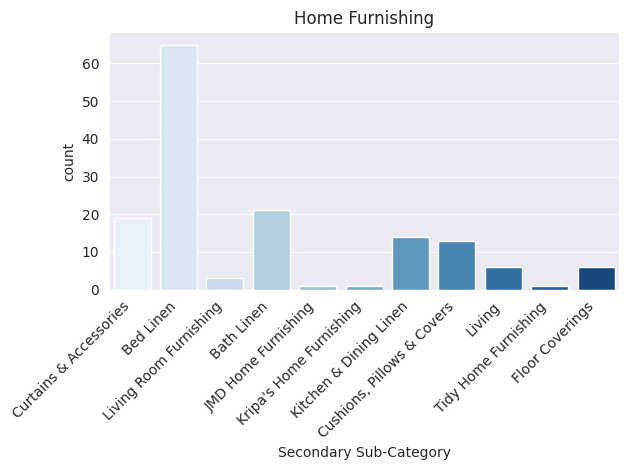

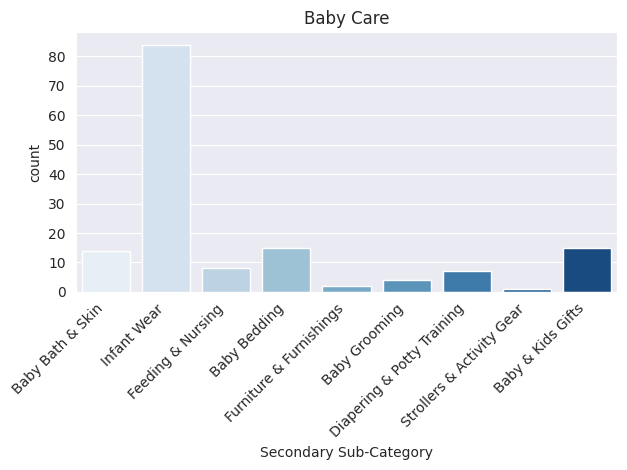

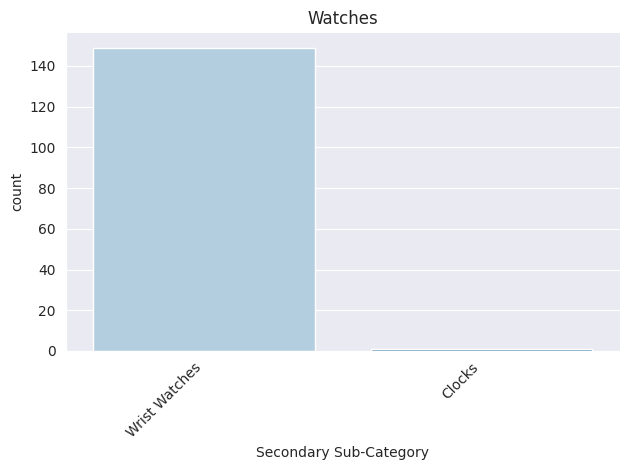

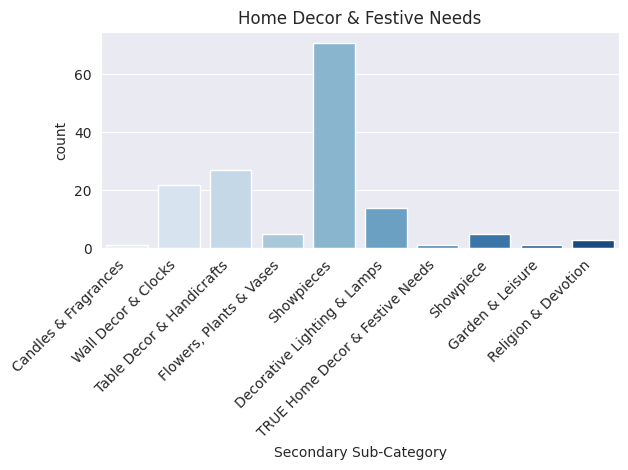

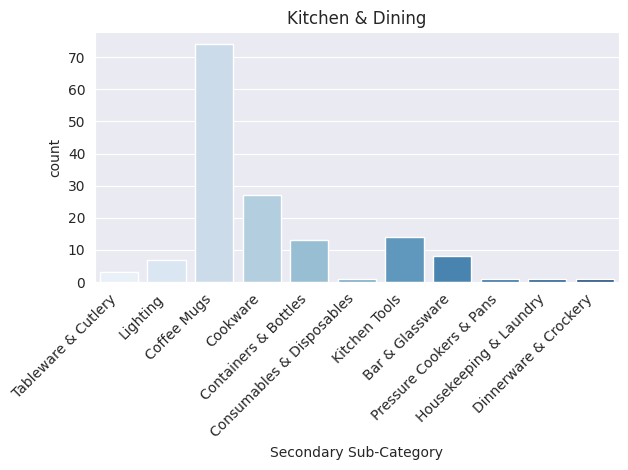

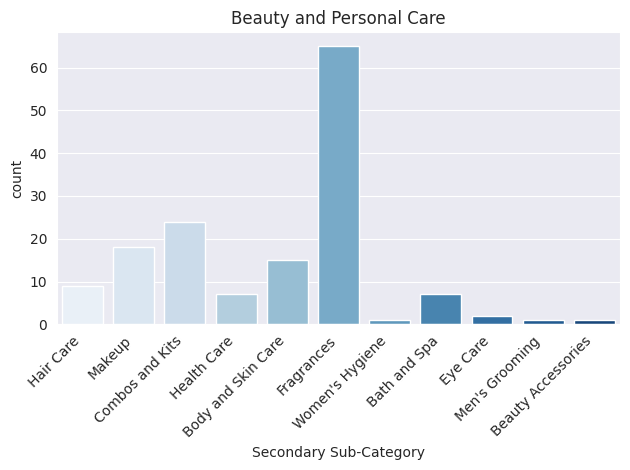

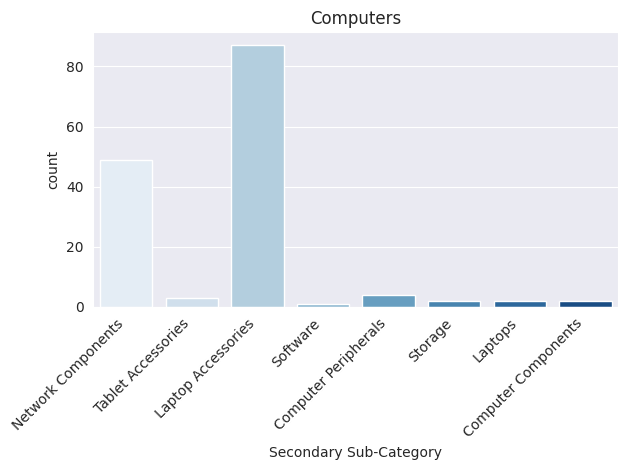

In [6]:
# Set the plot style using Seaborn
sns.set_style("darkgrid")

# For each unique main subcategory
for subcateg_1 in flipkart_w_subcat_df["subcateg_1"].unique().tolist():
    # Create a count plot for secondary subcategories in the current main subcategory
    sns.countplot(
        x="subcateg_2",
        data=flipkart_w_subcat_df.loc[flipkart_w_subcat_df["subcateg_1"] == subcateg_1],
        palette="Blues",
    )
    # Set the plot title as the current main subcategory
    plt.title(subcateg_1)
    # Configure the x-axis and the rotation of the labels
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Secondary Sub-Category")
    # Adjust the plot layout
    plt.tight_layout()
    # Show the plot
    plt.show()


## Affichage des profondeurs de l'arborescence des catégories

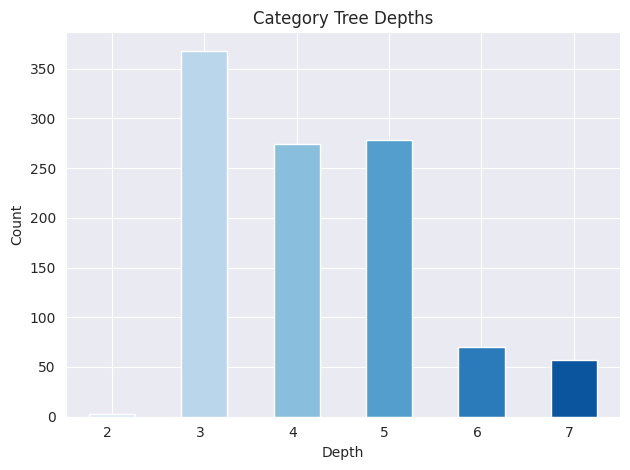

In [7]:
# Create a bar plot to visualize category tree depths
pd.Series(
    [len(x) for x in flipkart_w_subcat_df["product_category_tree"].to_list()]
).value_counts().sort_index().plot.bar(color=sns.color_palette("Blues").as_hex())

# Set the plot title
plt.title("Category Tree Depths")

# Configure the x-axis and the rotation of the labels
plt.xticks(rotation=0, ha="right")
plt.xlabel("Depth")
plt.ylabel("Count")

# Adjust the plot layout
plt.tight_layout()

# Show the plot
plt.show()


## Suppression des informations de catégorie des spécifications des produits

In [8]:
# Define a function to remove the "Category" key from product specifications
def remove_prod_spec_categ(row):
    if "Category" in row["product_specifications"].keys():
        del row["product_specifications"]["Category"]

    return row


# Apply the function to the rows of the DataFrame
flipkart_w_subcat_df = flipkart_w_subcat_df.apply(
    remove_prod_spec_categ, axis=1)


## Ajout d'une colonne pour les spécifications des produits sous forme de chaîne
- Définir une fonction pour ajouter une colonne "product_specifications_str" contenant les spécifications des produits sous forme de chaîne de caractères
- Appliquer la fonction aux lignes du DataFrame
- Afficher la première ligne du DataFrame modifié

In [9]:
# Define a function to add a column "product_specifications_str" with product specifications as a string
def add_prod_spec_str(row):
    if len(row["product_specifications"].items()) > 0:
        row["product_specifications_str"] = " ".join(
            list(row["product_specifications"].values())
        )
    else:
        row["product_specifications_str"] = ""

    return row


# Apply the function to the rows of the DataFrame
flipkart_w_subcat_df = flipkart_w_subcat_df.apply(add_prod_spec_str, axis=1)

# Display the first row of the modified DataFrame
flipkart_w_subcat_df.head(1)


product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   

                               product_category_tree  \
0  [Home Furnishing, Curtains & Accessories, Curt...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   

                              product_specifications       subcateg_1  \
0  {'Brand': 'Elegance', 'Designed For': 'Door', ...  Home Furnishing   

               subcateg_2 subcateg_3  \
0  Curtains & Accessories   Curtains   

                                         subcateg_4 subcateg_5 subcateg_6  \
0  Elegance Polyester Multicolor Abstract Eyelet Do        NaN        NaN   

  subcateg_7                         product_specifications_str  
0        NaN  Elegance Door Eyelet Abstract Polyester Door C...

## Prétraitement des caractéristiques textuelles
- Initialisation des variables et des objets nécessaires pour le prétraitement
- Définition de plusieurs fonctions pour effectuer les étapes de prétraitement :
    - `to_lower` : convertir le texte en minuscules
    - `add_tokens` : tokenizer le texte
    - `del_stpwrd_pnct` : supprimer les mots vides et la ponctuation
    - `lemmatize` : lemmatiser les tokens
- Application des fonctions de prétraitement aux lignes du DataFrame
- Affichage de la première ligne du DataFrame prétraité

In [10]:
# Initialize variables and objects needed for preprocessing
preproc_feats = ["product_name", "description", "product_specifications_str"]
tokenized_feats = [x + "_tokens" for x in preproc_feats]
stopwords = nltk.corpus.stopwords.words("english")
punctuation = list(punctuation)
lemmatizer = nltk.stem.WordNetLemmatizer()

# Define function to convert text to lowercase
def to_lower(row):
    for preproc_feat in preproc_feats:
        row[preproc_feat] = row[preproc_feat].lower()

    return row

# Define function to tokenize text
def add_tokens(row):
    for preproc_feat in preproc_feats:
        row[preproc_feat +
            "_tokens"] = nltk.tokenize.word_tokenize(row[preproc_feat])

    return row

# Define function to remove stopwords and punctuation
def del_stpwrd_pnct(row):
    for tokenized_feat in tokenized_feats:
        row[tokenized_feat] = [
            x
            for x in row[tokenized_feat]
            if x not in stopwords and x not in punctuation
        ]

    return row

# Define function to lemmatize tokens
def lemmatize(row):
    for tokenized_feat in tokenized_feats:
        row[tokenized_feat] = [lemmatizer.lemmatize(
            x) for x in row[tokenized_feat]]

    return row

# Apply preprocessing functions to the rows of the DataFrame
flipkart_w_subcat_df = flipkart_w_subcat_df.apply(to_lower, axis=1)
flipkart_w_subcat_df = flipkart_w_subcat_df.apply(add_tokens, axis=1)
flipkart_w_subcat_df = flipkart_w_subcat_df.apply(del_stpwrd_pnct, axis=1)
flipkart_w_subcat_df = flipkart_w_subcat_df.apply(lemmatize, axis=1)

# Display the first row of the preprocessed DataFrame
flipkart_w_subcat_df.head(1)


product_name  \
0  elegance polyester multicolor abstract eyelet ...   

                               product_category_tree  \
0  [Home Furnishing, Curtains & Accessories, Curt...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   

                                         description  \
0  key features of elegance polyester multicolor ...   

                              product_specifications       subcateg_1  \
0  {'Brand': 'Elegance', 'Designed For': 'Door', ...  Home Furnishing   

               subcateg_2 subcateg_3  \
0  Curtains & Accessories   Curtains   

                                         subcateg_4 subcateg_5 subcateg_6  \
0  Elegance Polyester Multicolor Abstract Eyelet Do        NaN        NaN   

  subcateg_7                         product_specifications_str  \
0        NaN  elegance door eyelet abstract polyester door c...   

                                 product_name_tokens  \
0  [elegance, polyester, multicolor, abstract, ey...   

                                  description_tokens  \
0  [key, feature, elegance, polyester, multicolor...   

                   product_specifications_str_tokens  
0  [elegance, door, eyelet, abstract, polyester, ...

## Statistiques de mots par catégorie et caractéristique
- Définir une fonction `word_stats_by_categ_feat` pour afficher les statistiques de mots par catégorie et caractéristique textuelle
    - Paramètre `num_top_words` : nombre de mots les plus fréquents à afficher
- Pour chaque catégorie principale, la fonction affiche :
    - Les `num_top_words` mots les plus fréquents pour chaque caractéristique textuelle
    - La liste de tous les mots uniques pour chaque caractéristique textuelle
    - Le nombre de mots uniques pour chaque caractéristique textuelle
    - Le nombre de mots uniques pour les caractéristiques précédentes combinées
- Appeler la fonction `word_stats_by_categ_feat` pour afficher les statistiques de mots

In [11]:
# Define a function to display word statistics by category and text feature
def word_stats_by_categ_feat(num_top_words=10):
    for main_categ in flipkart_w_subcat_df["subcateg_1"].unique():
        categ_df = flipkart_w_subcat_df.loc[
            flipkart_w_subcat_df["subcateg_1"] == main_categ
        ]
        previous_combined = []

        print(f"Primary category: {main_categ}")

        for tokenized_feat in tokenized_feats:
            top_words_list = (
                pd.Series(
                    list(np.concatenate(categ_df[tokenized_feat].to_list()).flat))
                .value_counts()
                .nlargest(n=num_top_words)
                .index.to_list()
            )

            print(
                f"\t{num_top_words} top words in {tokenized_feat}:\n\t\t{top_words_list}"
            )

            all_words_list = (
                pd.Series(
                    list(np.concatenate(categ_df[tokenized_feat].to_list()).flat))
                .unique()
                .tolist()
            )

            print(f"\tAll words in {tokenized_feat}:\n\t{all_words_list}")

            previous_combined += all_words_list

            previous_combined = list(set(previous_combined))

            print(
                f"\tNumber of words in {tokenized_feat}: {len(all_words_list)}")
            print(
                f"\tNumber of words in previous features combined: {len(previous_combined)}"
            )

# Call the word_stats_by_categ_feat function to display word statistics
word_stats_by_categ_feat()


Primary category: Home Furnishing
	10 top words in product_name_tokens:
		['cotton', 'single', 'abstract', 'double', 'floral', 'cover', 'quilt', 'blanket', 'comforter', 'polyester']
	All words in product_name_tokens:
	['elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'santosh', 'royal', 'fashion', 'cotton', 'printed', 'king', 'sized', 'double', 'bedsheet', 'jaipur', 'print', 'floral', 'embroidered', 'diwan', 'set', 'house', 'queen', 'duvet', 'cover', 'riva', 'carpet', 'free', 'bath', 'mat', 'classic', 'loop', 'shag', 'bathmat_ri-527', 'jmd', 'cushion', 'kripa', "'s", 'prime', '4', 'seater', 'table', '8', 'craft', 'trade', 'oval', 'wood', 'coaster', 'rama', 'single', 'quilt', 'comforter', 'pink-red', 'yellow', 'shop', 'rajasthan', 'dohar', 'artisan', 'creation', 'checkered', 'brown', 'blue-beige', 'remtex', 'export', 'cartoon', 'india', 'bhavya', 'velvet', 'sofa', 'dreamshomes', 'jewelkraft', 'design', 'pink', 'linen', 'tidy', 'jbc', 'collection', 'lushome

## Nuage de mots pour la catégorie "Home Furnishing"
- Créer un sous-ensemble de `flipkart_w_subcat_df` pour la catégorie "Home Furnishing"
- Concaténer tous les tokens des caractéristiques "product_name" et "description" dans une chaîne de caractères
- Créer un nuage de mots à partir de cette chaîne de caractères en utilisant WordCloud
- Afficher le nuage de mots

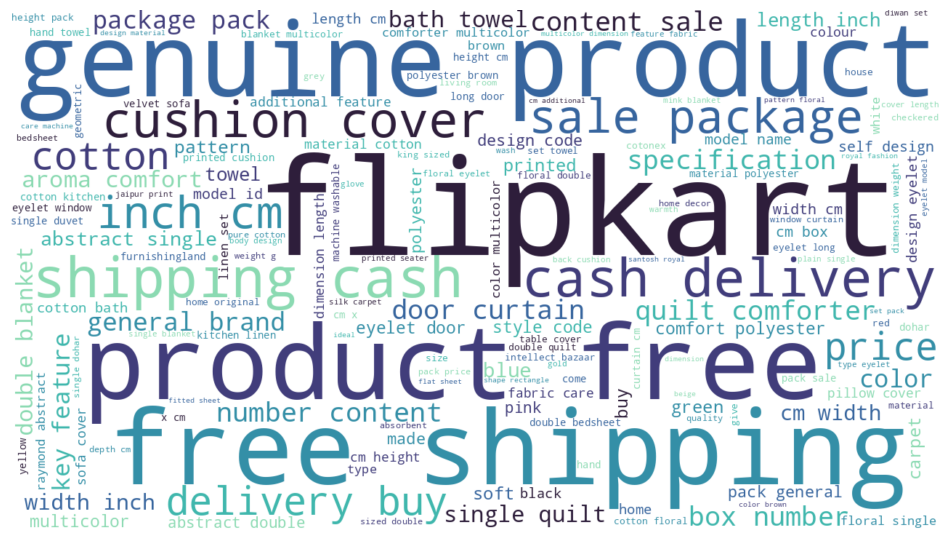

In [12]:
# Create a subset of flipkart_w_subcat_df for the "Home Furnishing" category
home_furnishing_df = flipkart_w_subcat_df.loc[
    flipkart_w_subcat_df["subcateg_1"] == "Home Furnishing"
]
# Concatenate all tokens from the "product_name" and "description" features into a single string
home_furnishing_words = " ".join(
    list(np.concatenate(
        home_furnishing_df["product_name_tokens"].to_list()).flat)
    + list(np.concatenate(home_furnishing_df["description_tokens"].to_list()).flat)
)
# Create a word cloud from the string using WordCloud
wordcloud = WordCloud(
    width=1280,
    height=720,
    background_color="white",
    min_font_size=10,
    colormap=ListedColormap(sns.color_palette("mako")),
).generate(home_furnishing_words)

# Display the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## Suppression du bruit dans les tokens
- Définir une expression régulière `noise_patrn` pour détecter les tokens bruités
    - Cible les tokens tels que les URLs, les numéros de modèle, les chaînes de chiffres et les suffixes orphelins
- Créer une fonction `remove_noise` pour supprimer les tokens bruités en fonction de l'expression régulière
- Appliquer la fonction `remove_noise` à `flipkart_w_subcat_df` et stocker le résultat dans un nouveau- DataFrame `flipkart_w_subcat_wo_noise_df`

In [13]:
# Define a regular expression pattern to detect noisy tokens
noise_patrn = re.compile(r".*?\w\.\w.*|.*?\d+.*|^'.*|^-.*|^.$|.*?/.*")

# Create a function to remove noisy tokens based on the regular expression pattern
def remove_noise(row):
    for tokenized_feat in tokenized_feats:
        row[tokenized_feat] = [
            x for x in row[tokenized_feat] if not re.match(noise_patrn, x)
        ]

    return row

# Apply the remove_noise function to flipkart_w_subcat_df and store the result in a new DataFrame
flipkart_w_subcat_wo_noise_df = flipkart_w_subcat_df.apply(
    remove_noise, axis=1)


## Suppression des mots non pertinents
Les mots non pertinents sont identifiés et supprimés de l'ensemble de données en fonction de deux critères :
- Pertinence inter-catégorie : Un mot est considéré comme non pertinent s'il apparaît dans plus de 2 catégories principales différentes. Cela signifie qu'il n'est pas assez spécifique pour être utile dans la différenciation des catégories.
- Pertinence intra-catégorie : Un mot est considéré comme non pertinent s'il apparaît dans moins de 2 % des entrées d'une catégorie principale. Cela signifie qu'il n'est pas assez fréquent pour être utile dans la différenciation des produits au sein de cette catégorie.

Après avoir identifié les mots non pertinents, ils sont supprimés des colonnes "product_name_tokens" et "description_tokens".

In [14]:
# Set thresholds for identifying irrelevant words
inter_categ_thresh = 2  # Word is irrelevant if found in more than 2 categories
intra_categ_thresh = 0.02  # Word is irrelevant if found in less than 2% of category entries

# Initialize dictionaries and lists for word counts and irrelevant words
word_counts_by_categ = {}
words_to_remove_by_inter_categ = {}
words_to_remove_by_intra_categ = {}
entries_per_categ = {}
main_categ_list = flipkart_w_subcat_wo_noise_df["subcateg_1"].unique()
known_irrel_words = [
    "buy",
    "genuine",
    "product",
    "day",
    "replacement",
    "guarantee",
    "free",
    "shipping",
    "cash",
    "delivery",
    "discount",
]

# Calculate word counts by category and identify words to remove based on thresholds
for main_categ in main_categ_list:
    categ_df = flipkart_w_subcat_wo_noise_df.loc[
        flipkart_w_subcat_wo_noise_df["subcateg_1"] == main_categ
    ]
    # Get word counts for the current category
    word_counts_by_categ[main_categ] = (
        pd.Series(
            list(np.concatenate(
                categ_df["product_name_tokens"].to_list()).flat)
            + list(np.concatenate(categ_df["description_tokens"].to_list()).flat)
        )
        .value_counts()
        .to_dict()
    )
    # Get the number of entries in the current category
    entries_per_categ[main_categ] = categ_df.shape[0]
    # Initialize lists for irrelevant words
    words_to_remove_by_inter_categ[main_categ] = []
    words_to_remove_by_intra_categ[main_categ] = []

for main_categ in main_categ_list:
    other_categs_list = [x for x in main_categ_list if x != main_categ]
    # Calculate the intra-category threshold for the current category
    intra_categ_thresh_num = entries_per_categ[main_categ] * intra_categ_thresh

    for word in word_counts_by_categ[main_categ].keys():
        other_categs_found_in = 0

        for other_categ in other_categs_list:
            if word in word_counts_by_categ[other_categ].keys():
                other_categs_found_in += 1

        # If the word appears in more categories than the threshold, mark it as irrelevant
        if other_categs_found_in > inter_categ_thresh:
            words_to_remove_by_inter_categ[main_categ] += [word]

        # If the word appears in less entries than the threshold, mark it as irrelevant
        if word_counts_by_categ[main_categ][word] < intra_categ_thresh_num:
            words_to_remove_by_intra_categ[main_categ] += [word]

# Define a function to remove irrelevant words from tokenized feature columns
def remove_irrel_words(row, inter_categ_words_list, intra_categ_words_list):
    orig_product_name_tokens = row["product_name_tokens"].copy()
    orig_description_tokens = row["description_tokens"].copy()
    row["product_name_tokens"] = [
        x
        for x in row["product_name_tokens"]
        if x not in inter_categ_words_list + intra_categ_words_list
    ]
    row["description_tokens"] = [
        x
        for x in row["description_tokens"]
        if x not in inter_categ_words_list + intra_categ_words_list
    ]

    if len(row["product_name_tokens"]) == 0:
        row["product_name_tokens"] = [
            x for x in orig_product_name_tokens if x not in inter_categ_words_list
        ]

    if len(row["description_tokens"]) == 0:
        row["description_tokens"] = [
            x for x in orig_description_tokens if x not in inter_categ_words_list
        ]

    if len(row["product_name_tokens"]) == 0:
        row["product_name_tokens"] = [
            x for x in orig_product_name_tokens if x not in known_irrel_words
        ]

    if len(row["description_tokens"]) == 0:
        row["description_tokens"] = [
            x for x in orig_description_tokens if x not in known_irrel_words
        ]

    return row

# Create a copy of the DataFrame without noise
flipkart_no_irrel_df = flipkart_w_subcat_wo_noise_df.copy()

# Iterate through the main categories
for main_categ in main_categ_list:
    # Apply the remove_irrel_words function to the rows with the current main category
    flipkart_no_irrel_df.loc[
        flipkart_no_irrel_df["subcateg_1"] == main_categ
    ] = flipkart_no_irrel_df.loc[
        flipkart_no_irrel_df["subcateg_1"] == main_categ
    ].apply(
        remove_irrel_words,
        args=[
            words_to_remove_by_inter_categ[main_categ],
            words_to_remove_by_intra_categ[main_categ],
        ],
        axis=1,
    )


## Suppression des répétitions consécutives de mots
- Les répétitions consécutives de mots sont supprimées dans les colonnes `product_name_tokens` et `description_tokens`.
- Ensuite, les tokens nettoyés sont réassemblés pour recréer les chaînes de caractères nettoyées des colonnes `product_name` et `description`.

In [15]:
# Function to remove consecutive repeats from the tokenized features
def remove_repeats(row):
    tokens_feats = ["product_name_tokens", "description_tokens"]

    for tokens_feat in tokens_feats:
        repeats_removed = []
        last_token = ""

        for token in row[tokens_feat]:
            if token != last_token:
                repeats_removed += [token]

            last_token = token

        row[tokens_feat] = repeats_removed

    return row

# Function to insert cleaned strings into the DataFrame
def insert_cleaned_strings(row):
    row["product_name"] = " ".join(row["product_name_tokens"])
    row["description"] = " ".join(row["description_tokens"])

    return row

# Apply the remove_repeats and insert_cleaned_strings functions to the DataFrame
flipkart_no_irrel_df = flipkart_no_irrel_df.apply(remove_repeats, axis=1)
flipkart_clean_df = flipkart_no_irrel_df.apply(insert_cleaned_strings, axis=1)

# View one row to check results
flipkart_clean_df.head(1)


product_name  \
0  polyester eyelet door curtain   

                               product_category_tree  \
0  [Home Furnishing, Curtains & Accessories, Curt...   

                                  image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   

                                         description  \
0  polyester eyelet door curtain floral curtain p...   

                              product_specifications       subcateg_1  \
0  {'Brand': 'Elegance', 'Designed For': 'Door', ...  Home Furnishing   

               subcateg_2 subcateg_3  \
0  Curtains & Accessories   Curtains   

                                         subcateg_4 subcateg_5 subcateg_6  \
0  Elegance Polyester Multicolor Abstract Eyelet Do        NaN        NaN   

  subcateg_7                         product_specifications_str  \
0        NaN  elegance door eyelet abstract polyester door c...   

                  product_name_tokens  \
0  [polyester, eyelet, door, curtain]   

                                  description_tokens  \
0  [polyester, eyelet, door, curtain, floral, cur...   

                   product_specifications_str_tokens  
0  [elegance, door, eyelet, abstract, polyester, ...

## Visualisation du nuage de mots après le nettoyage des données
Un nuage de mots est généré pour la catégorie "Home Furnishing" en utilisant les chaînes nettoyées pour les colonnes `product_name` et `description`.

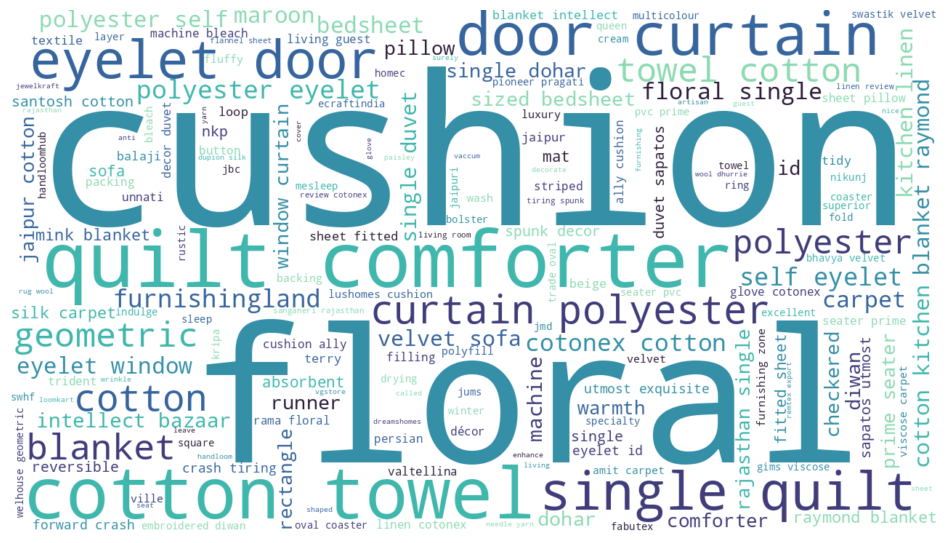

In [16]:
home_furnishing_df = flipkart_no_irrel_df.loc[
    flipkart_no_irrel_df["subcateg_1"] == "Home Furnishing"
]
home_furnishing_words = " ".join(
    list(np.concatenate(
        home_furnishing_df["product_name_tokens"].to_list()).flat)
    + list(np.concatenate(home_furnishing_df["description_tokens"].to_list()).flat)
)
wordcloud = WordCloud(
    width=1280,
    height=720,
    background_color="white",
    min_font_size=10,
    colormap=ListedColormap(sns.color_palette("mako")),
).generate(home_furnishing_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


## Visualisation des unigrammes et bigrammes les plus fréquents

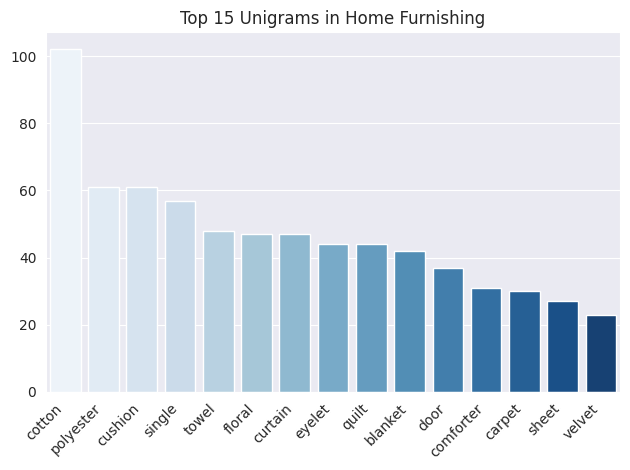

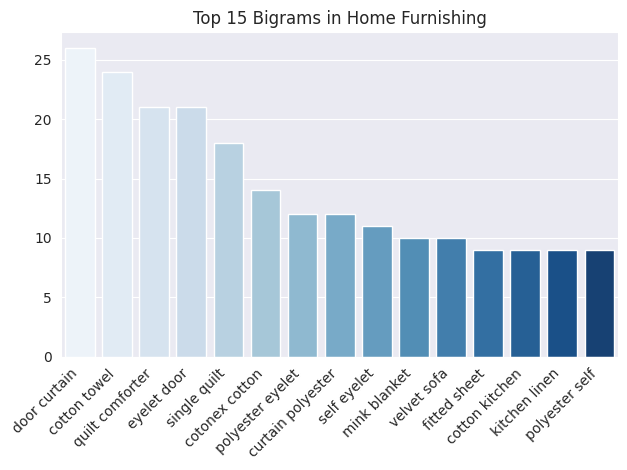

In [17]:
# Function to generate bigrams from description_tokens column
def generate_bigrams(row):
    desc_bigrams = []

    for i in range(len(row["description_tokens"]) - 1):
        desc_bigrams += [
            f"{row['description_tokens'][i]} {row['description_tokens'][i + 1]}"
        ]

    row["description_bigrams"] = desc_bigrams

    return row

# Applying the generate_bigrams function to the DataFrame
flipkart_w_bigram_df = flipkart_clean_df.apply(generate_bigrams, axis=1)

# Selecting the "Home Furnishing" category from the DataFrame with bigrams
home_furnishing_df = flipkart_w_bigram_df.loc[
    flipkart_w_bigram_df["subcateg_1"] == "Home Furnishing"
]

# Number of top n-grams to display
num_ngrams = 15

# Looping over the two feature types (unigrams and bigrams) to generate plots
for feat in [["description_tokens", "Unigrams"], ["description_bigrams", "Bigrams"]]:
    top_ngram_list = (
        pd.Series(
            list(np.concatenate(home_furnishing_df[feat[0]].to_list()).flat))
        .value_counts()
        .nlargest(n=num_ngrams)
    )

    # Plotting the top unigrams and bigrams
    sns.barplot(x=top_ngram_list.index,
                y=top_ngram_list.values, palette="Blues")
    plt.title(f"Top {num_ngrams} {feat[1]} in Home Furnishing")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


## Catégorisation via la modélisation de sujets et le clustering BoW
Dans cette partie, des modèles de classification et des méthodes de clustering sont utilisés pour regrouper les produits en fonction de leurs descriptions. Les méthodes employées sont les suivantes :
- LDA (Latent Dirichlet Allocation) pour la modélisation de sujets
- K-Means pour le clustering
- Comparaison de différentes méthodes de traitement du texte, comme la racinisation et les bigrammes

Simple Word Count, Unigrams Only - LDA Topics (Top 10 N-grams):
	Topic Kitchen & Dining: ['mug', 'coffee', 'laptop', 'happy', 'cheer', 'affordable', 'lapguard', 'holiday', 'say', 'find']
	Topic Baby Care: ['cotton', 'dress', 'towel', 'single', 'bedsheet', 'sonata', 'sheet', 'gathered', 'floral', 'pillow']
	Topic Home Decor & Festive Needs: ['showpiece', 'blanket', 'brass', 'pizza', 'oil', 'cutter', 'elephant', 'decor', 'handicraft', 'statue']
	Topic Watches: ['watch', 'analog', 'discount', 'dial', 'strap', 'mug', 'rockmantra', 'round', 'maximum', 'dishwasher']
	Topic Computers: ['laptop', 'usb', 'polyester', 'pad', 'curtain', 'mouse', 'eyelet', 'door', 'port', 'keyboard']
	Topic Kitchen & Dining: ['mug', 'coffee', 'cushion', 'kitchen', 'printland', 'huge', 'serve', 'prithish', 'fantastic', 'glass']
	Topic Beauty and Personal Care: ['adapter', 'sleeve', 'shirt', 'cotton', 'vaio', 'charger', 'laptop', 'neck', 'smartpro', 'regular']
Simple Word Count, Unigrams and Bigrams - LDA Topics (To

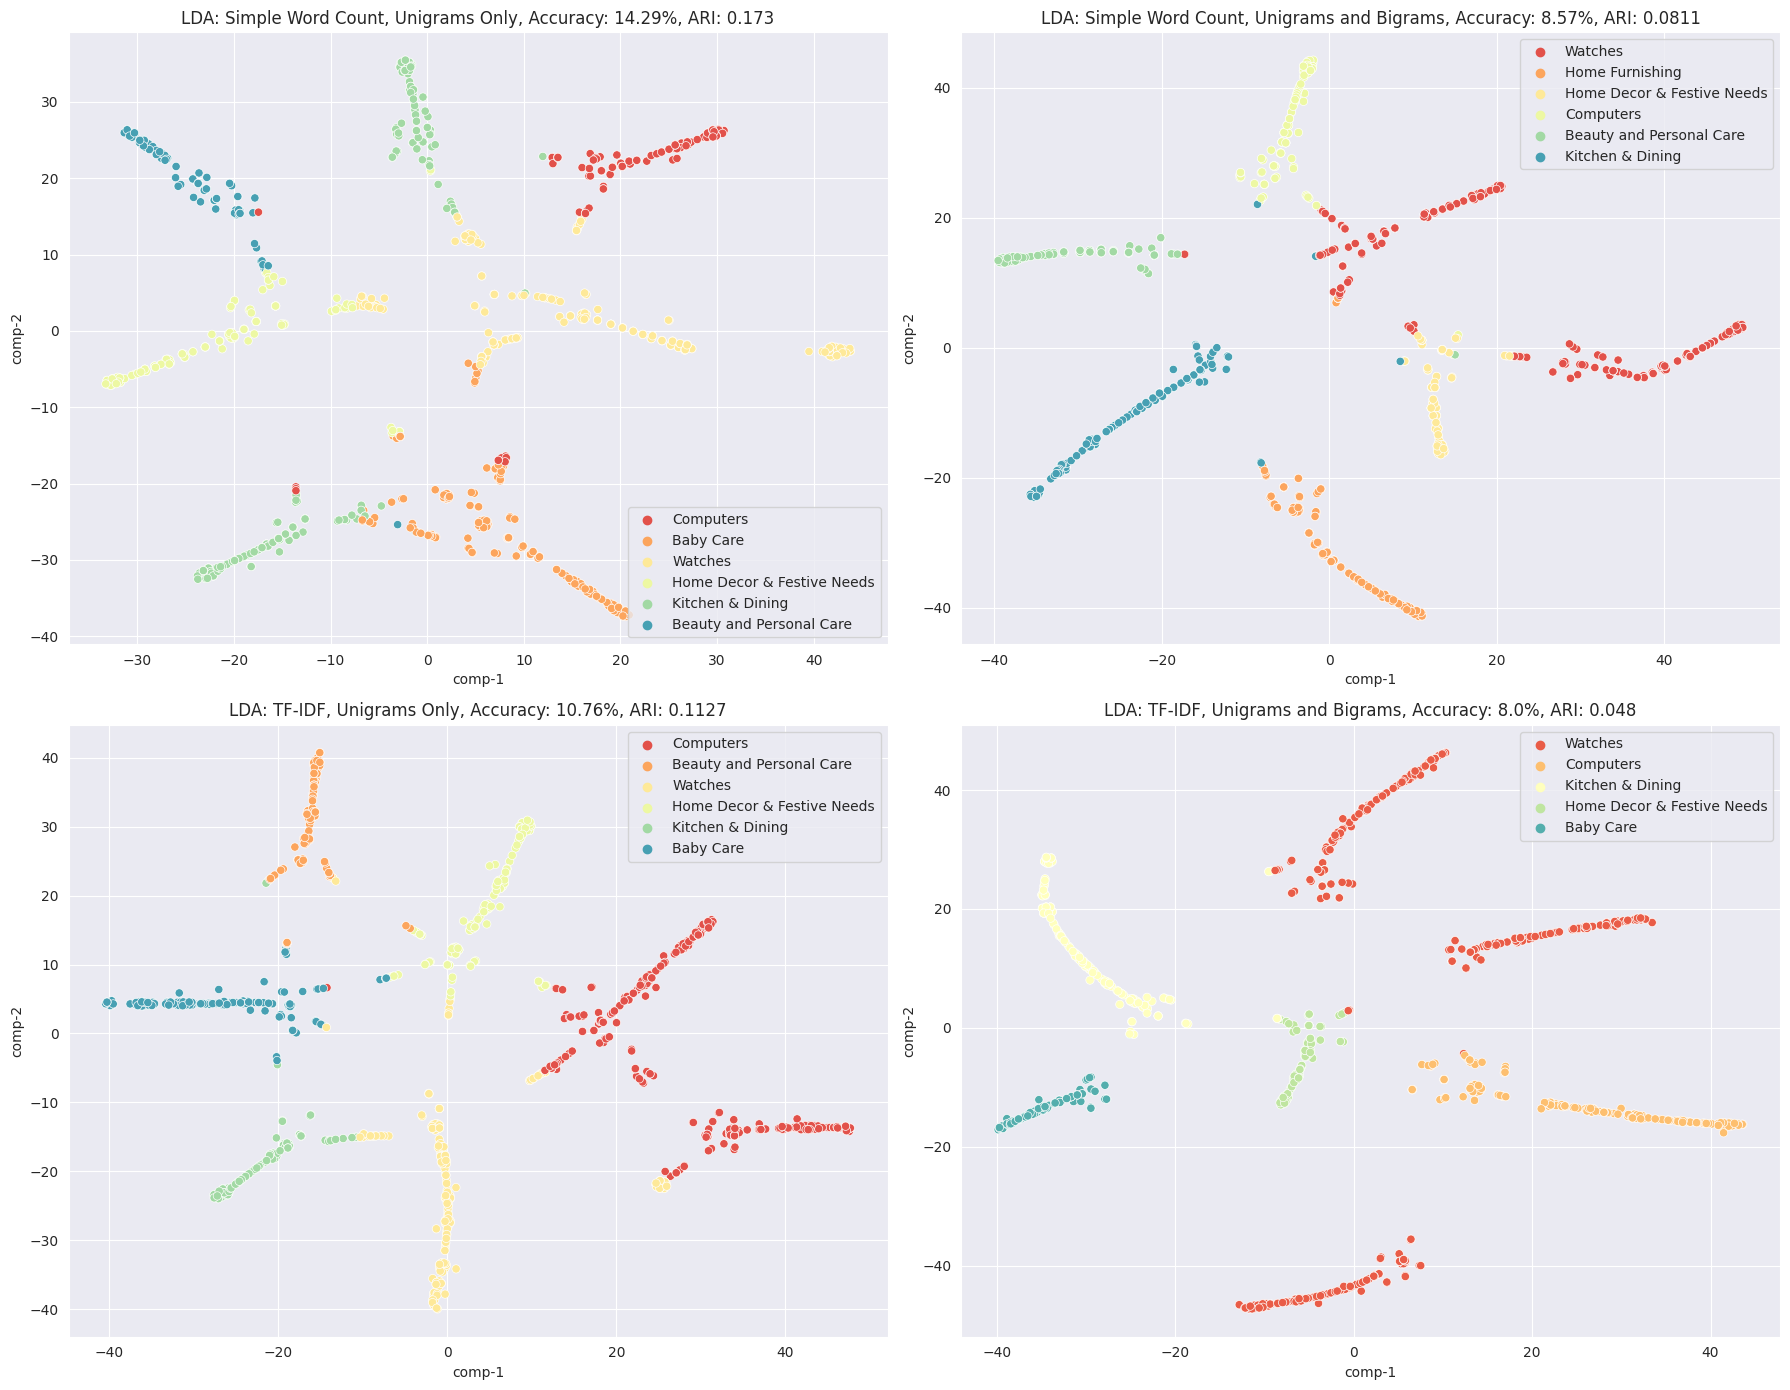

Simple Word Count, Unigrams Only, Stemmed - LDA Topics (Top 10 N-grams):
	Topic Watches: ['watch', 'analog', 'discount', 'dial', 'strap', 'round', 'maximum', 'sonata', 'idol', 'ganesha']
	Topic Computers: ['usb', 'port', 'oil', 'fan', 'carpet', 'poster', 'android', 'phone', 'devic', 'otg']
	Topic Home Furnishing: ['cotton', 'mug', 'towel', 'coffe', 'singl', 'bedsheet', 'cushion', 'sheet', 'quilt', 'printland']
	Topic Baby Care: ['cotton', 'dress', 'sleev', 'neck', 'occas', 'shirt', 'round', 'gather', 'regular', 'stripe']
	Topic Home Decor & Festive Needs: ['showpiec', 'pizza', 'sticker', 'hair', 'decor', 'brass', 'cutter', 'paint', 'frame', 'eleph']
	Topic Kitchen & Dining: ['laptop', 'mug', 'rockmantra', 'pad', 'polyest', 'dishwash', 'microwav', 'curtain', 'glass', 'start']
	Topic Computers: ['mug', 'adapt', 'laptop', 'coffe', 'vaio', 'charger', 'usb', 'smartpro', 'cell', 'lapguard']
Simple Word Count, Unigrams and Bigrams, Stemmed - LDA Topics (Top 10 N-grams):
	Topic Home Furnishing

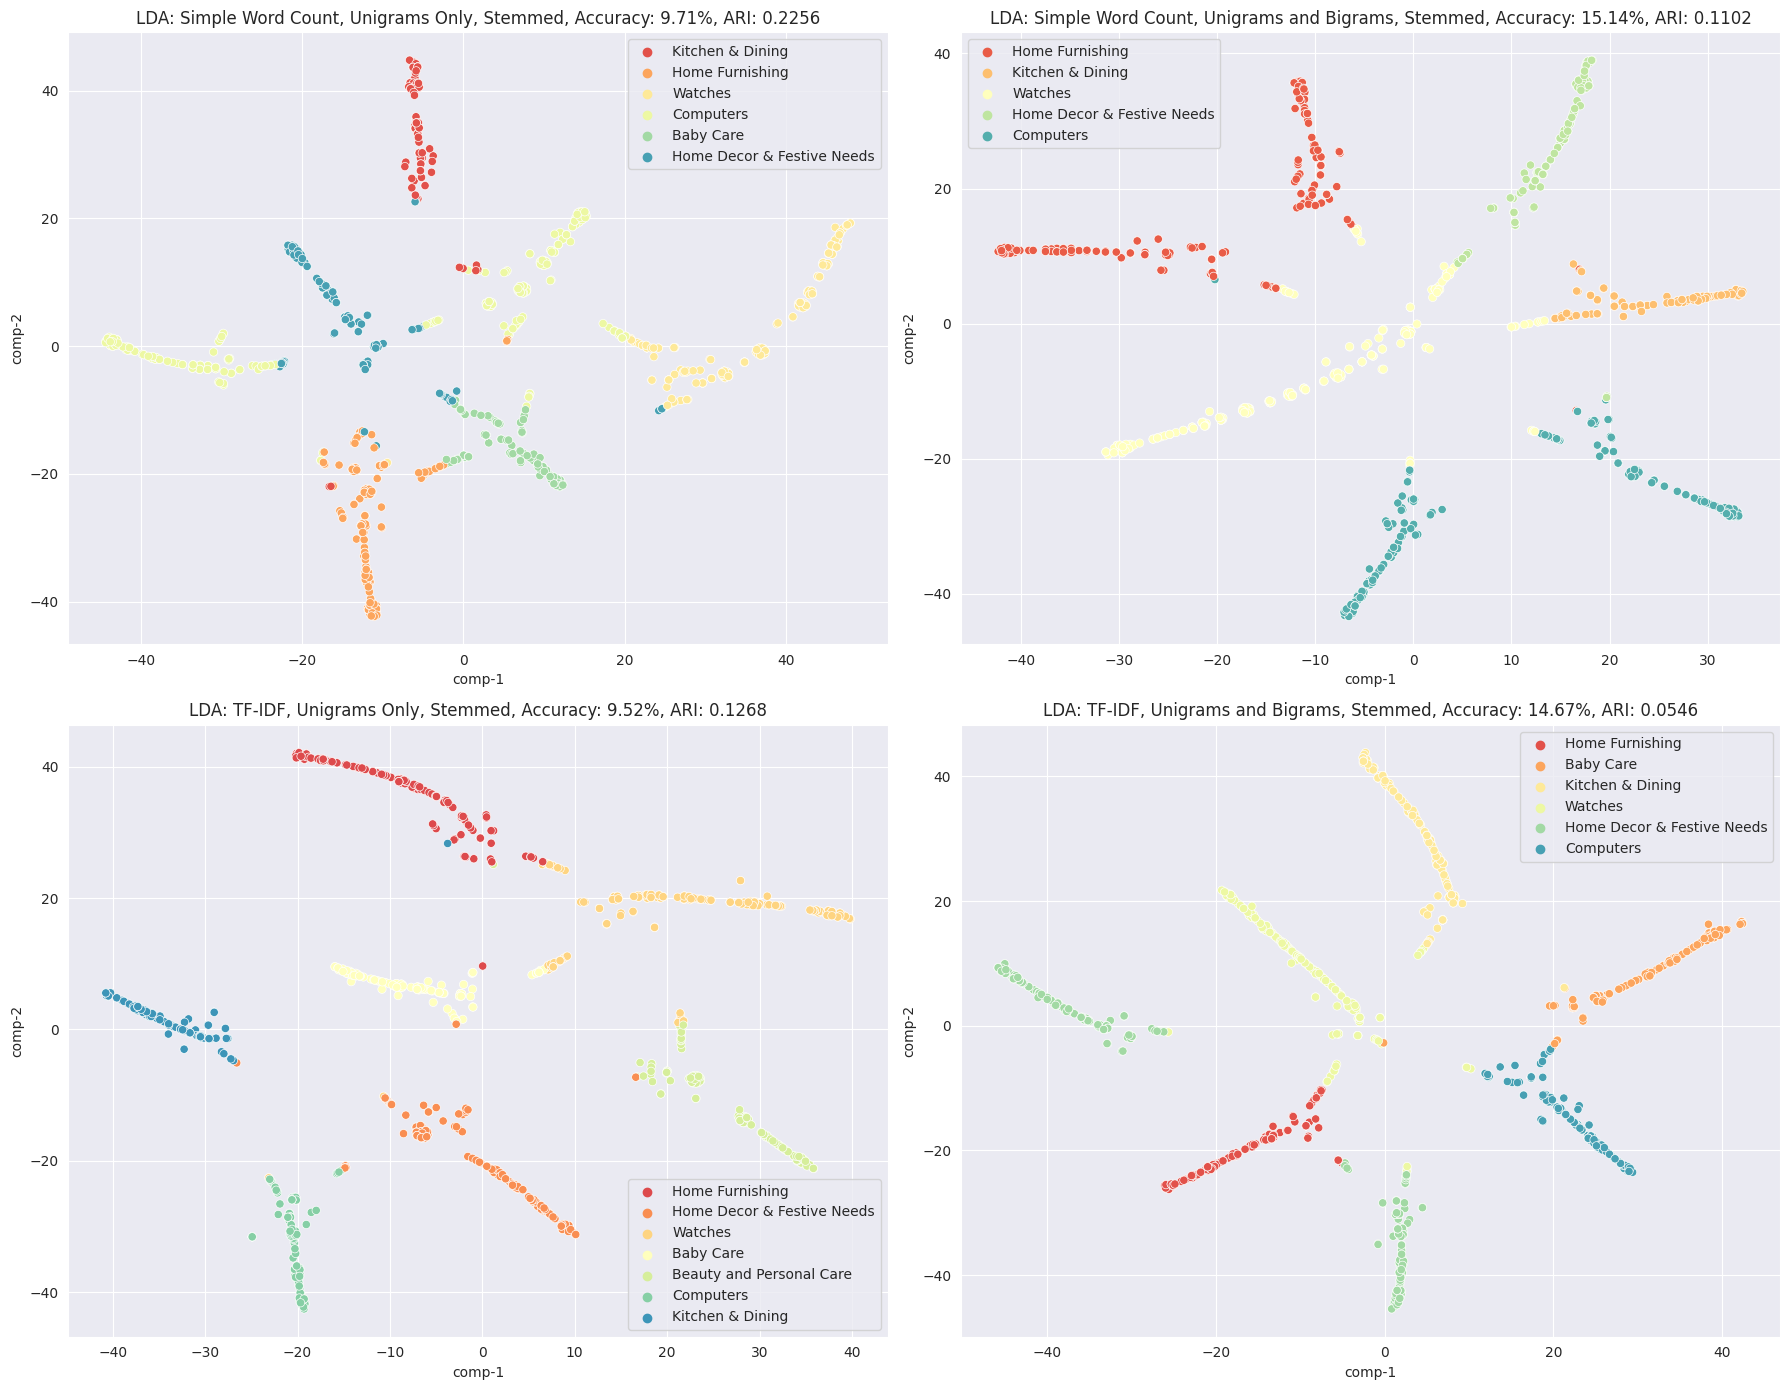

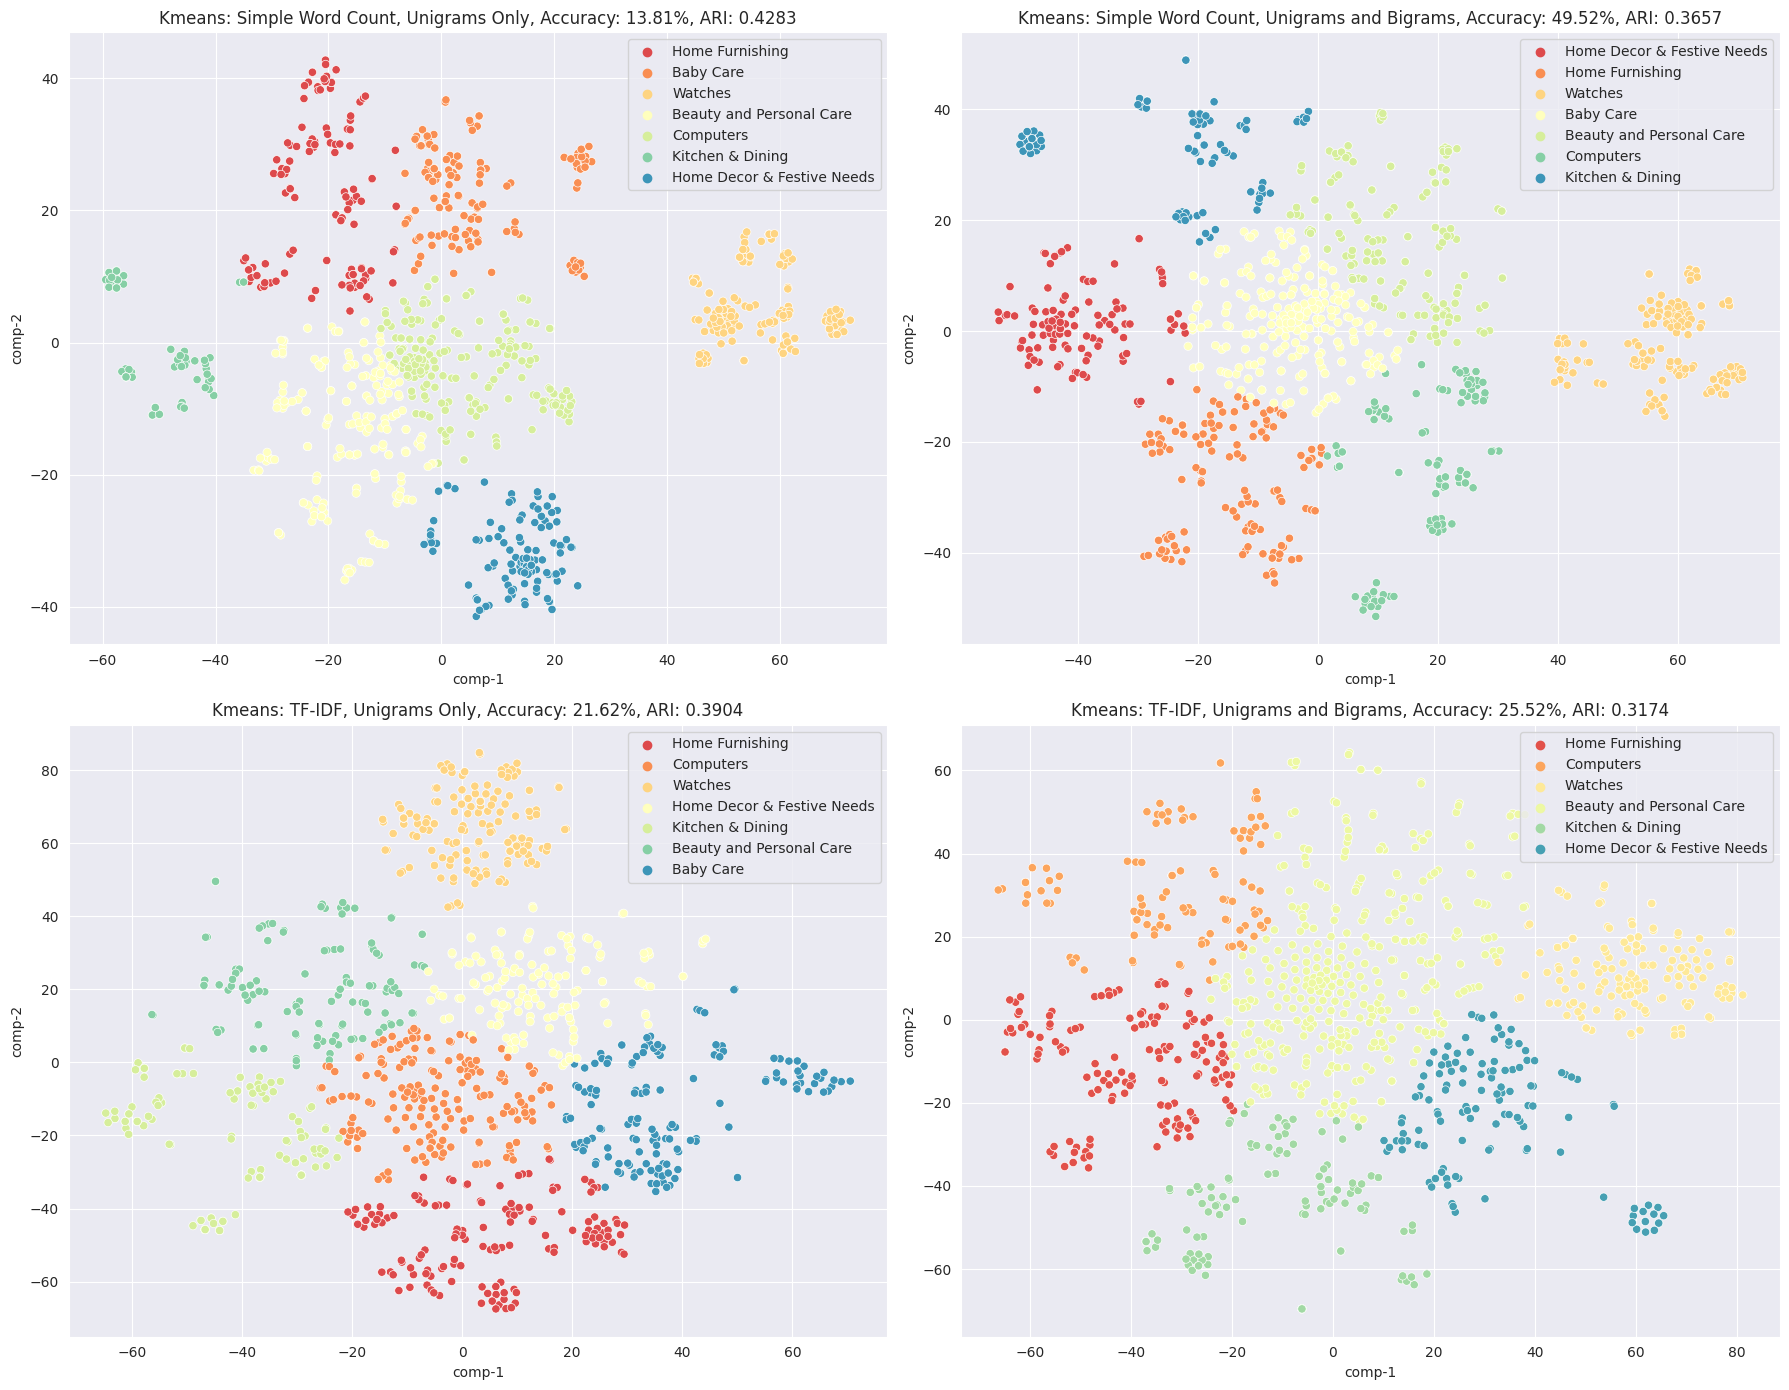

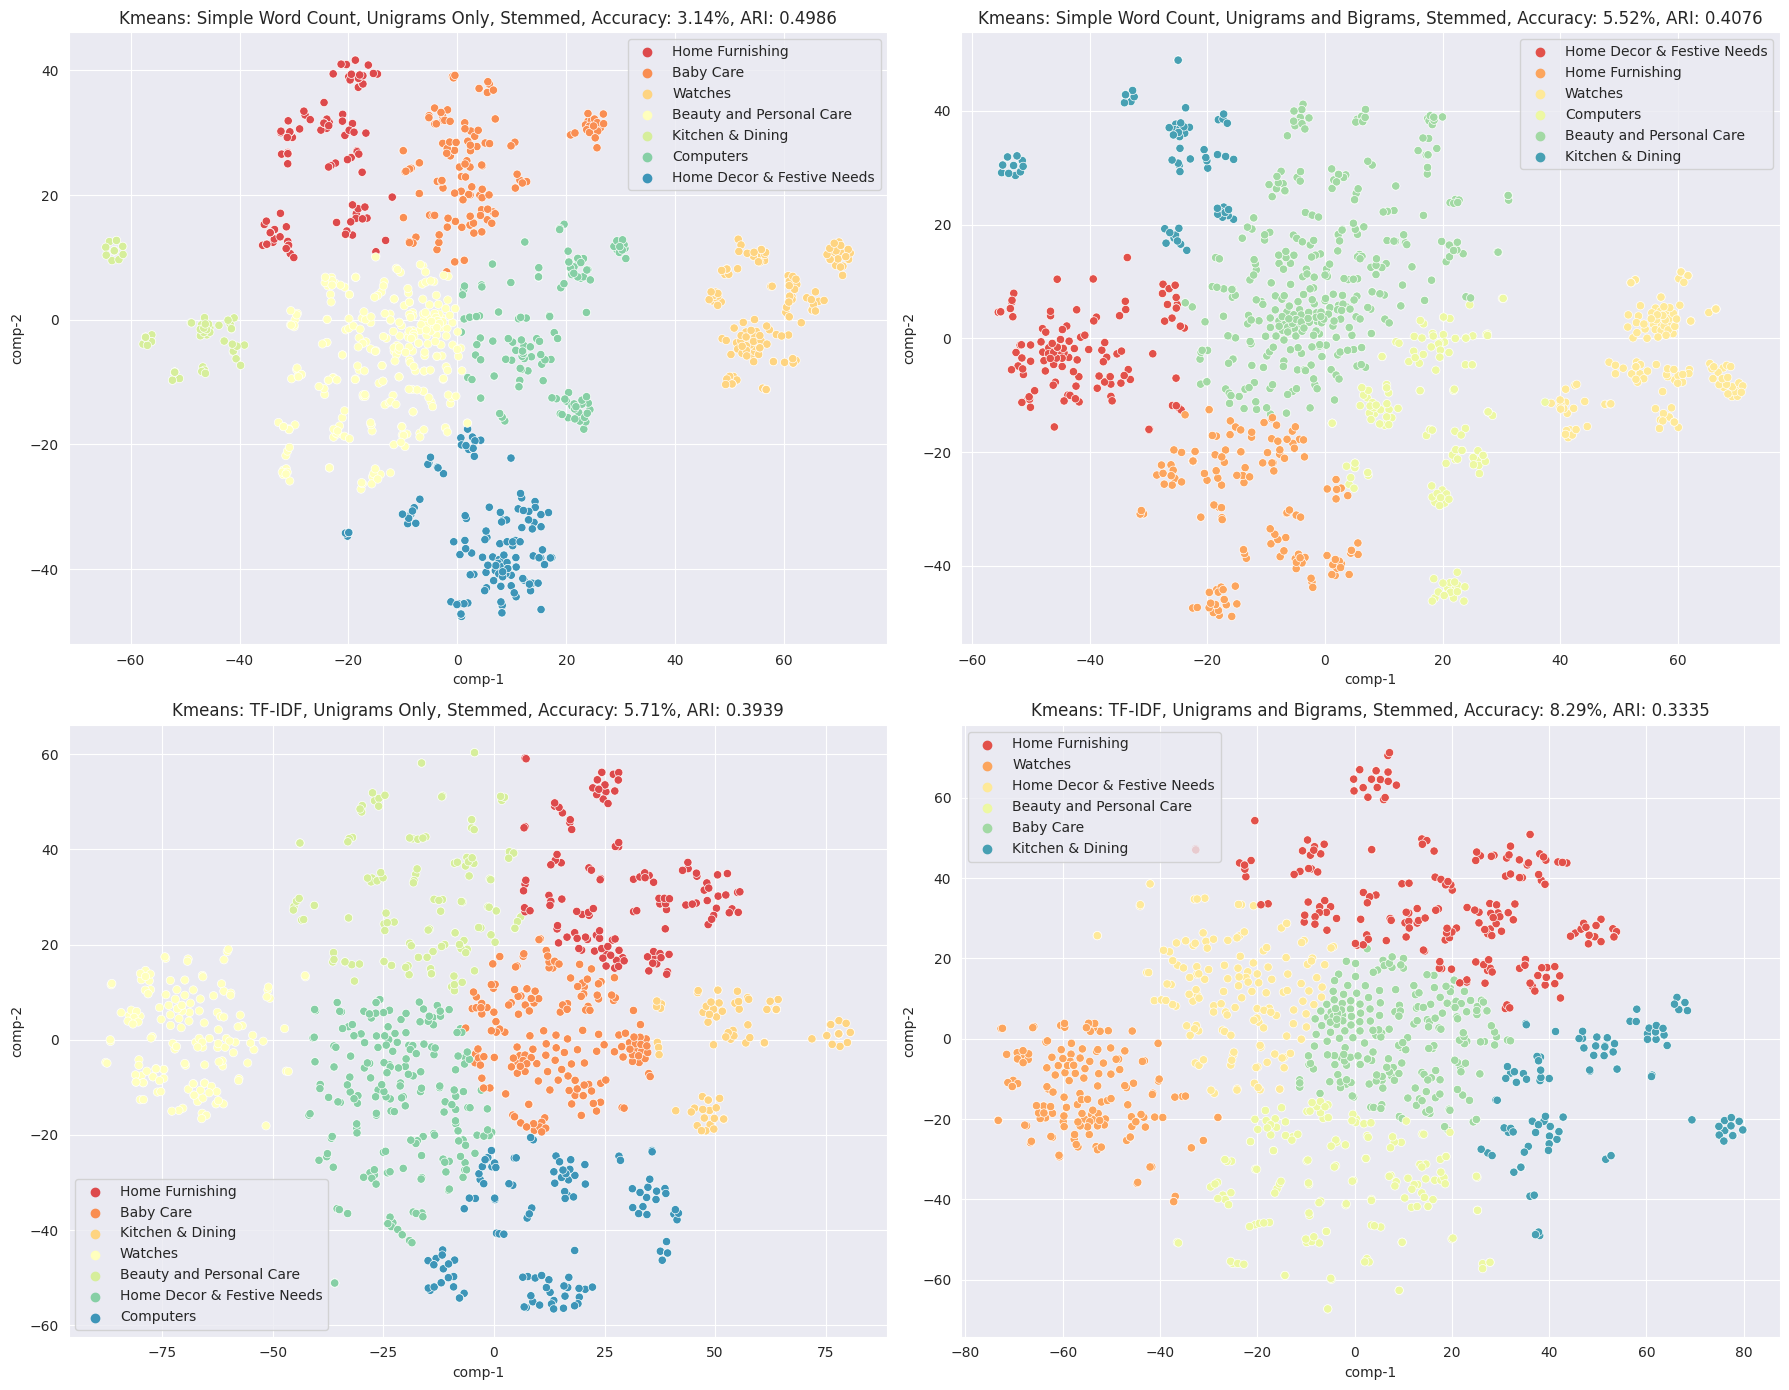

In [18]:
# Set the number of topics, unique category names, and initialize models
n_topics = len(flipkart_clean_df["subcateg_1"].unique().tolist())
true_categ_names_list = flipkart_clean_df["subcateg_1"].to_list()
true_labels = [
    np.where(np.array(list(dict.fromkeys(true_categ_names_list)))
             == categ)[0][0]
    for categ in true_categ_names_list
]
docs = flipkart_clean_df["description"].to_list()
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=0)
kmeans_model = KMeans(n_clusters=n_topics, n_init=10, random_state=0)


# Function to get stemmed strings from a list of strings
def get_stemmed_str_list(str_list):
    return [
        " ".join([nltk.stem.PorterStemmer().stem(x) for x in y.split()])
        for y in str_list
    ]


# Function to generate BoW vectors and feature names
def get_bow_vector_and_feat_names(docs, w_bigram=False, tfidf=False):
    ngram_range = (1, 2) if w_bigram else (1, 1)
    vectorizer = (
        TfidfVectorizer(ngram_range=ngram_range)
        if tfidf
        else CountVectorizer(ngram_range=ngram_range)
    )
    vector = vectorizer.fit_transform(docs)
    feat_names = vectorizer.get_feature_names_out()

    return {"vector": vector, "feat_names": feat_names}


# Function to get PCA transformed data with specified explained variance via binary search
def get_pca_transformed_w_exp_var(matrix, exp_var=0.9):
    if isinstance(matrix, list):
        matrix = np.array(matrix)
    elif isinstance(matrix, scipy.sparse._csr.csr_matrix):
        matrix = matrix.toarray()
    elif not isinstance(matrix, np.ndarray):
        raise Exception(
            "matrix must be of type `list` or `scipy.sparse._csr.csr_matrix`"
        )

    min_comp = min(matrix.shape)
    n_comp = min_comp
    denom = 2
    step = min_comp // denom

    while step >= 1:
        pca = PCA(n_components=n_comp, random_state=0).fit(matrix)
        explained_variance = sum(pca.explained_variance_ratio_)
        n_comp = n_comp - step if explained_variance > exp_var else n_comp + step
        denom *= 2
        step = min_comp // denom

    return pca.transform(matrix)


# Function to get 2D t-SNE projection of input data
def get_2d_tsne(matrix):
    return TSNE(n_components=2, init="random", random_state=0).fit_transform(matrix)


# Function to perform dimensionality reduction via PCA and t-SNE
def fit_transform_via_pca_tsne(matrix):
    return get_2d_tsne(get_pca_transformed_w_exp_var(matrix))


# Function to map predicted labels to true category names
def get_named_labels_and_num_to_name(pred_labels, true_categ_names_list):
    label_num_to_name = {}

    for pred_label in sorted(set(pred_labels)):
        categ_name = (
            pd.Series(
                [
                    true_categ_names_list[j]
                    for j in [
                        i
                        for i in range(len(pred_labels))
                        if pred_labels[i] == pred_label
                    ]
                ]
            )
            .value_counts()
            .idxmax()
        )

        label_num_to_name[pred_label] = categ_name
        pred_labels = [
            x if x != pred_label else categ_name for x in pred_labels]

    return [pred_labels, label_num_to_name]


# Function to create different BoW matrices based on stemming flag
def get_bow_matrices(stemmed=False):
    return {
        "Simple Word Count, Unigrams Only"
        + (", Stemmed" if stemmed else ""): get_bow_vector_and_feat_names(
            get_stemmed_str_list(docs) if stemmed else docs
        ),
        "Simple Word Count, Unigrams and Bigrams"
        + (", Stemmed" if stemmed else ""): get_bow_vector_and_feat_names(
            get_stemmed_str_list(docs) if stemmed else docs, w_bigram=True
        ),
        "TF-IDF, Unigrams Only"
        + (", Stemmed" if stemmed else ""): get_bow_vector_and_feat_names(
            get_stemmed_str_list(docs) if stemmed else docs, tfidf=True
        ),
        "TF-IDF, Unigrams and Bigrams"
        + (", Stemmed" if stemmed else ""): get_bow_vector_and_feat_names(
            get_stemmed_str_list(docs) if stemmed else docs, w_bigram=True, tfidf=True
        ),
    }


# Function to plot predictions from BoW models
def plot_bow_preds(lda=False, stemmed=False):
    ax_idx = 0
    fig, axs = plt.subplots(nrows=2, ncols=2)
    axs = axs.flatten()
    bow_matrices = get_bow_matrices(stemmed=stemmed)
    lda_str = ""

    fig.set_figwidth(18)
    fig.set_figheight(14)

    for bow_matrix_key in bow_matrices.keys():
        if lda:
            lda_matrix = lda_model.fit_transform(
                bow_matrices[bow_matrix_key]["vector"])
            lda_labels = lda_matrix.argmax(axis=1)
            named_labels, topic_num_to_name_dict = get_named_labels_and_num_to_name(
                lda_labels, true_categ_names_list
            )
            lda_str += f"{bow_matrix_key} - LDA Topics (Top 10 N-grams):\n"

            for index, component in enumerate(lda_model.components_):
                topic_top_feat_list = list(
                    dict(
                        sorted(
                            zip(bow_matrices[bow_matrix_key]
                                ["feat_names"], component),
                            key=lambda x: x[1],
                            reverse=True,
                        )[:10]
                    ).keys()
                )
                lda_str += (
                    f"\tTopic {topic_num_to_name_dict[index]}: {topic_top_feat_list}\n"
                )

            tsne = get_2d_tsne(lda_matrix)

            axs[ax_idx].set_title(
                f"LDA: {bow_matrix_key}, Accuracy: {round(accuracy_score(true_labels, lda_labels) * 100, 2)}%"
                + f", ARI: {round(adjusted_rand_score(true_labels, lda_labels), 4)}"
            )
        else:
            tsne = fit_transform_via_pca_tsne(
                bow_matrices[bow_matrix_key]["vector"])
            pred_labels = kmeans_model.fit(tsne).labels_
            named_labels, topic_num_to_name_dict = get_named_labels_and_num_to_name(
                pred_labels, true_categ_names_list
            )

            axs[ax_idx].set_title(
                f"Kmeans: {bow_matrix_key}, Accuracy: {round(accuracy_score(true_labels, pred_labels) * 100, 2)}%"
                + f", ARI: {round(adjusted_rand_score(true_labels, pred_labels), 4)}"
            )

        sns.scatterplot(
            data=pd.DataFrame(
                {
                    "pred_labels": named_labels,
                    "comp-1": tsne[:, 0],
                    "comp-2": tsne[:, 1],
                }
            ),
            x="comp-1",
            y="comp-2",
            hue="pred_labels",
            palette=sns.color_palette("Spectral", len(set(named_labels))),
            ax=axs[ax_idx],
        )
        axs[ax_idx].legend()
        ax_idx += 1

    if lda:
        print(lda_str)

    plt.tight_layout()
    plt.show()


# Plot predictions based on various permutations of LDA/Bow (swc/tf-idf), stemmed/not stemmed
plot_bow_preds(lda=True)
plot_bow_preds(lda=True, stemmed=True)
plot_bow_preds()
plot_bow_preds(stemmed=True)


## Fonction pour le clustering et la représentation graphique d'une matrice de vecteurs
- Le clustering est effectué après diverses techniques de réduction de la dimensionnalité
    - Les éléments sont regroupés en clusters directement sur les vecteurs
    - Réduction PCA des vecteurs avant le clustering
    - Réduction t-SNE des vecteurs avant le clustering
    - Réduction PCA et t-SNE des vecteurs avant le clustering
- La précision et l'indice de rand ajusté (ARI) sont calculés pour les étiquettes de catégorie résultant des divers clustering.
- La représentation graphique est générée pour le clustering ayant la meilleure moyenne de métrique.

In [19]:
def cluster_plot_vectors(model_name, vectors):
    # Perform PCA to get components with specified explained variance
    pca_components = get_pca_transformed_w_exp_var(vectors)
    
    # Perform t-SNE on original vectors
    tsne = get_2d_tsne(np.array(vectors))
    
    # Perform t-SNE on PCA reduced components
    pca_tsne = get_2d_tsne(pca_components)
    
    # Create different clustering approaches with dimensionality reduction techniques
    dimen_reduc_clusterings = [
        ["Clustered on Vectors Directly", kmeans_model.fit(vectors).labels_, tsne],
        ["Clustered on PCA Reduced", kmeans_model.fit(pca_components).labels_, pca_tsne],
        ["Clustered on TSNE Reduced", kmeans_model.fit(tsne).labels_, tsne],
        ["Clustered on PCA and TSNE Reduced", kmeans_model.fit(pca_tsne).labels_, pca_tsne]
    ]
    
    # Initialize variables to store best clustering result
    best_metric_avg = -0.5
    best_clustering = {}

    # Iterate through different clustering approaches
    for dimen_reduc_clustering in dimen_reduc_clusterings:
        accuracy = accuracy_score(true_labels, dimen_reduc_clustering[1])
        ari = adjusted_rand_score(true_labels, dimen_reduc_clustering[1])
        metric_avg = (accuracy + ari) / 2
        title = f"{model_name} ({dimen_reduc_clustering[0]}); " + \
            f"Accuracy: {round(accuracy * 100, 2)}%, ARI: {round(ari, 4)}"

        print(title)

        # Update the best clustering result if the current approach has a higher average metric
        if metric_avg > best_metric_avg:
            best_metric_avg = metric_avg
            best_clustering = {
                "labels": dimen_reduc_clustering[1],
                "tsne": dimen_reduc_clustering[2],
                "title": title
            }

    # Get named labels for the best clustering result
    named_labels, topic_num_to_name_dict = get_named_labels_and_num_to_name(
        best_clustering["labels"], true_categ_names_list
    )
    
    # Plot the best clustering result
    fig, ax = plt.subplots(nrows=1, ncols=1)

    fig.set_figwidth(10)
    fig.set_figheight(8)
    ax.set_title(best_clustering["title"])
    sns.scatterplot(
        data=pd.DataFrame(
            {
                "labels": named_labels,
                "comp-1": best_clustering["tsne"][:, 0],
                "comp-2": best_clustering["tsne"][:, 1],
            }
        ),
        x="comp-1",
        y="comp-2",
        hue="labels",
        palette=sns.color_palette("Spectral", len(set(named_labels))),
        ax=ax,
    )
    ax.legend()
    plt.tight_layout()
    plt.show()


## Embedding de document et clustering avec BERT
BERT (Bidirectional Encoder Representations from Transformers) est un modèle de traitement de langage naturel qui permet de représenter chaque document sous forme de vecteur de haute dimension.
- Les documents sont convertis en vecteurs
- Les vecteurs de documents sont regroupés en clusters en utilisant l'algorithme de clustering KMeans combiné à différentes techniques de réduction de dimensionnalité
- La précision et le score ARI sont calculés pour évaluer la qualité des clusters
- Les résultats de clustering avec les meilleures performances sont affichés

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT (Clustered on Vectors Directly); Accuracy: 21.62%, ARI: 0.2931
BERT (Clustered on PCA Reduced); Accuracy: 25.14%, ARI: 0.3061
BERT (Clustered on TSNE Reduced); Accuracy: 7.14%, ARI: 0.4372
BERT (Clustered on PCA and TSNE Reduced); Accuracy: 26.1%, ARI: 0.4294


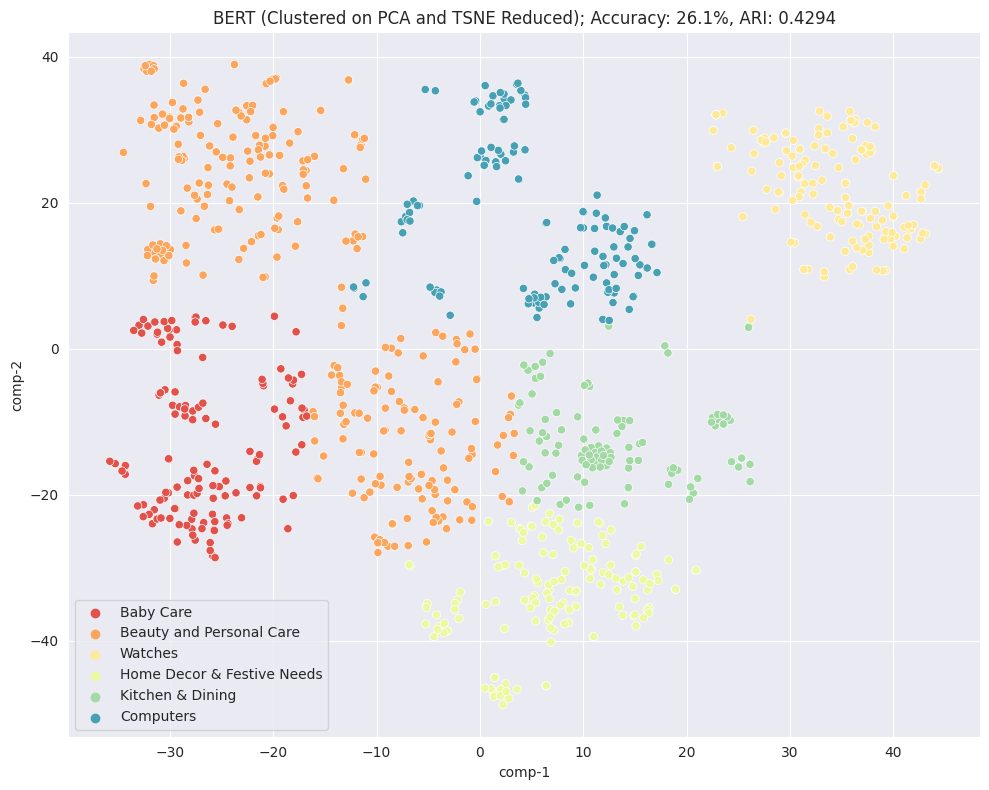

In [20]:
# Load the pre-trained BERT model and tokenizer
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Initialize list for document embeddings
bert_doc_embeddings = []

for i, doc in enumerate(docs):
    # Tokenize the description and encode it as an input tensor
    input_ids = torch.tensor(bert_tokenizer.encode(doc)).unsqueeze(0)

    with torch.no_grad():
        # Pass the input tensor through the BERT model and select the last hidden layer
        last_hidden_states = bert_model(input_ids)[0]
        
        # Compute the mean of the last hidden layer values to generate a document embedding
        document_embedding = torch.mean(last_hidden_states, dim=1).numpy()[0]
        bert_doc_embeddings.append(document_embedding)

# Cluster and plot the document embeddings using the `cluster_plot_vectors()` function
cluster_plot_vectors("BERT", bert_doc_embeddings)


## Embedding de document et clustering avec Doc2Vec

Doc2Vec (Clustered on Vectors Directly); Accuracy: 16.19%, ARI: 0.051
Doc2Vec (Clustered on PCA Reduced); Accuracy: 10.57%, ARI: 0.0489
Doc2Vec (Clustered on TSNE Reduced); Accuracy: 15.71%, ARI: 0.1876
Doc2Vec (Clustered on PCA and TSNE Reduced); Accuracy: 14.76%, ARI: 0.1513


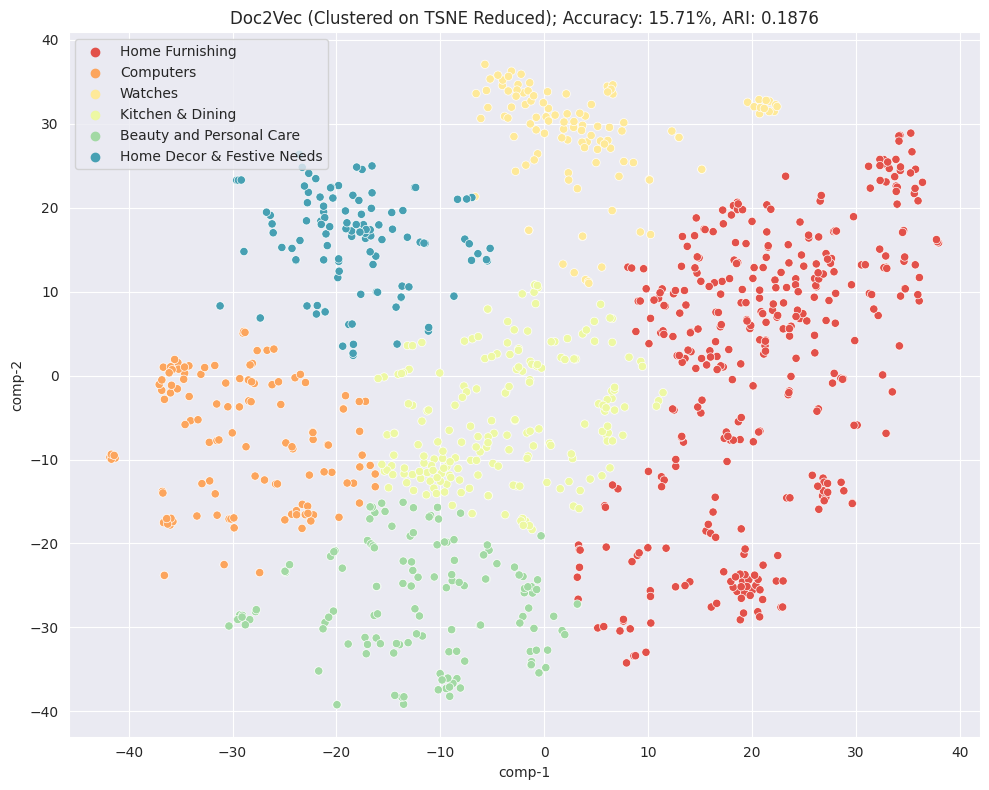

In [21]:
# create TaggedDocument objects for each document
tagged_docs = [
    TaggedDocument(words=doc.split(), tags=[i]) for i, doc in enumerate(docs)
]
# train the Doc2Vec model on the TaggedDocuments
doc2vec_model = Doc2Vec(tagged_docs, vector_size=300,
                        window=5, min_count=1, epochs=50)
# infer the vector for each document using the trained model
doc2vec_model_vectors = [doc2vec_model.infer_vector(
    doc.words) for doc in tagged_docs]
# plot the clustered vectors
cluster_plot_vectors("Doc2Vec", doc2vec_model_vectors)


## Embedding de document et clustering avec l'Universal Sentence Encoder

2023-03-29 15:15:16.648937: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gabriel/OC_DS_Projects/OC_DS_P6/venv/lib/python3.8/site-packages/cv2/../../lib64:
2023-03-29 15:15:16.658158: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-29 15:15:16.658222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2023-03-29 15:15:16.671534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the

USE (Clustered on Vectors Directly); Accuracy: 9.33%, ARI: 0.443
USE (Clustered on PCA Reduced); Accuracy: 10.1%, ARI: 0.4415
USE (Clustered on TSNE Reduced); Accuracy: 21.43%, ARI: 0.5351
USE (Clustered on PCA and TSNE Reduced); Accuracy: 31.24%, ARI: 0.5429


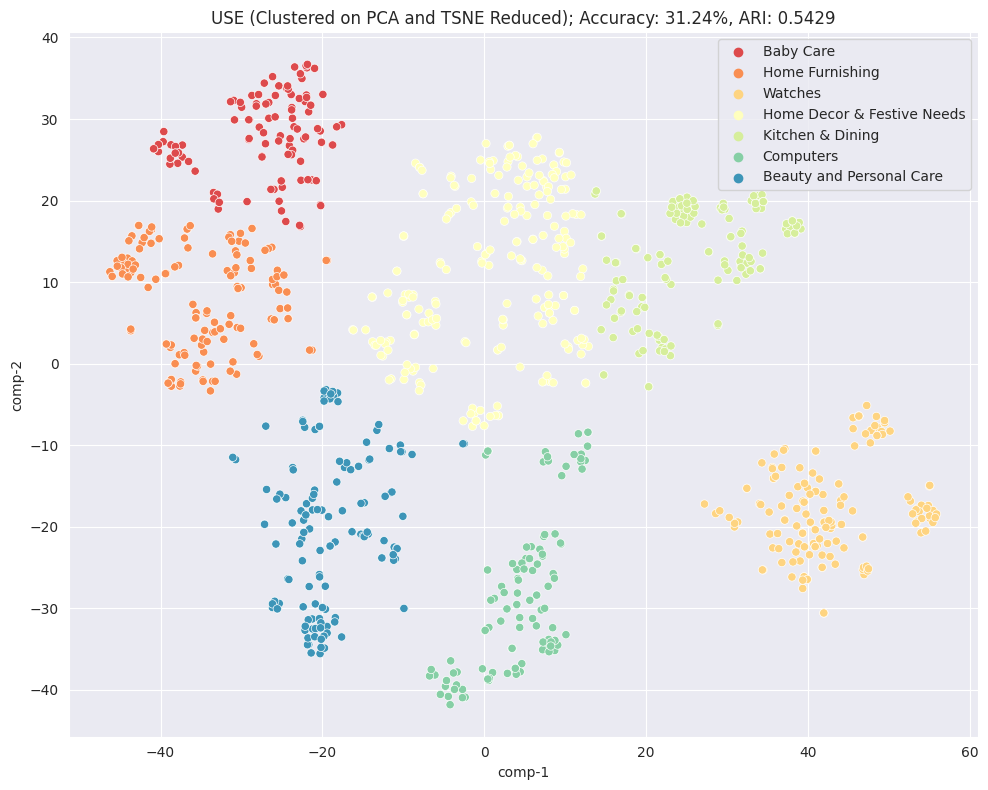

In [22]:
# Load the Universal Sentence Encoder Large module from TensorFlow Hub
use_embeddings = hub.load(
    "https://tfhub.dev/google/universal-sentence-encoder-large/5"
)(docs)
# Plot the clustered vectors
cluster_plot_vectors("USE", [list(x) for x in use_embeddings.numpy()])


## Bag-of-Visual-Words avec ORB
Le Bag-of-Visual-Words (BoVW) est une méthode de représentation visuelle qui consiste à regrouper les descripteurs d'images en un vocabulaire visuel, puis à quantifier les occurrences de chaque mot visuel dans chaque image.

ORB (Oriented FAST and Rotated BRIEF) est un algorithme de détection de points d'intérêt et de description d'images qui peut être utilisé pour extraire des descripteurs à partir d'images.

Les étapes de prétraitement sont les suivantes:
- Les images sont redimensionnées pour avoir une hauteur ou une largeur de 500 pixels, tout en conservant un ratio hauteur/largeur compris entre 0,8 et 1,25.
- Les images sont converties en niveaux de gris.
- Les images sont floutées et ajustées en contraste pour améliorer la qualité des points d'intérêt détectés.

Les images prétraitées sont ensuite traitées selon les étapes suivantes:
- Les descripteurs sont extraits des images à l'aide de l'algorithme ORB.
- Les descripteurs sont regroupés en un vocabulaire visuel de taille spécifiée.
- Les histogrammes d'images sont construits en comptant les occurrences de chaque mot visuel dans chaque image.
- Les images sont représentées sous forme de vecteurs d'histogrammes.

Si le fichier img_histograms.pkl existe déjà, le programme lit le fichier. Sinon, il prétraite les images, construit le vocabulaire visuel et calcule les histogrammes d'images, puis sauvegarde les histogrammes d'images dans le fichier img_histograms.pkl. Enfin, il affiche la visualisation des clusters.

Les vecteurs d'histogrammes sont regroupés en clusters en utilisant l'algorithme de clustering KMeans combiné à différentes techniques de réduction de dimensionnalité

La précision et le score ARI sont calculés pour évaluer la qualité des clusters

Les résultats de clustering avec les meilleures performances sont affichés

Les 15 mots visuels les plus fréquents pour quelques images sont également affichés.

BoVW with ORB (Clustered on Vectors Directly); Accuracy: 13.43%, ARI: 0.0276
BoVW with ORB (Clustered on PCA Reduced); Accuracy: 16.38%, ARI: 0.0197
BoVW with ORB (Clustered on TSNE Reduced); Accuracy: 11.71%, ARI: 0.035
BoVW with ORB (Clustered on PCA and TSNE Reduced); Accuracy: 13.71%, ARI: 0.0358


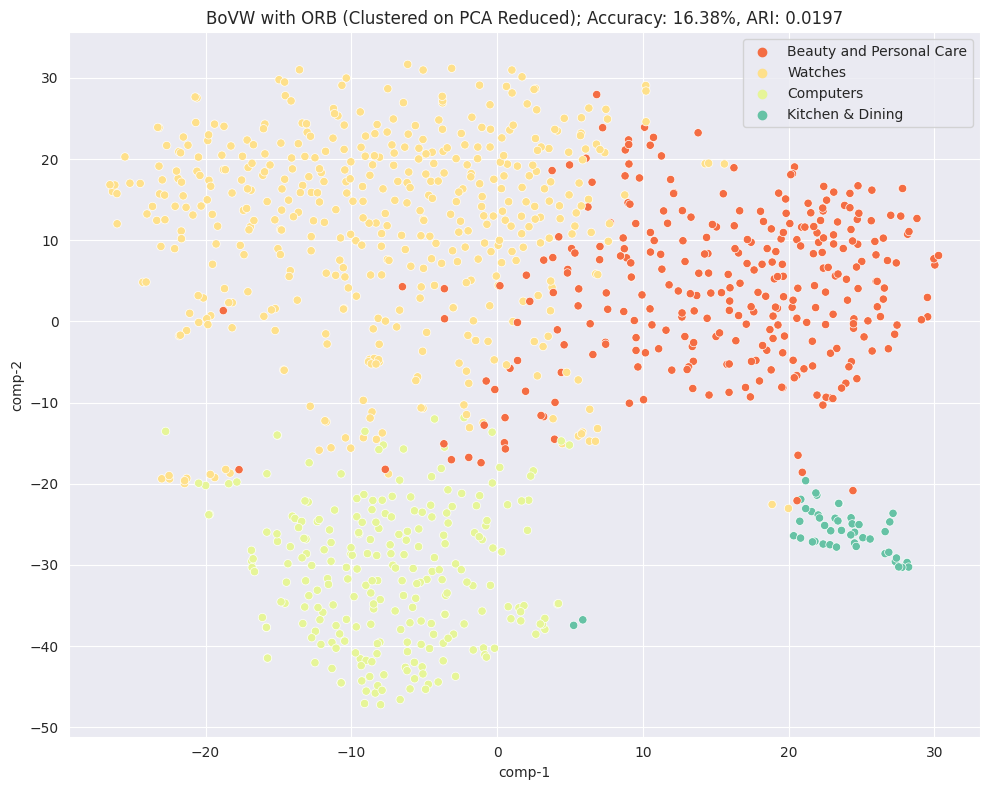

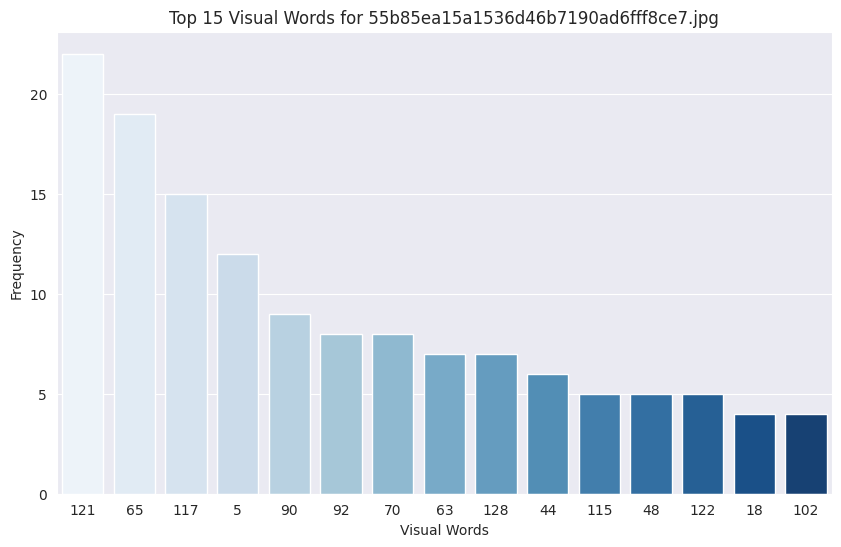

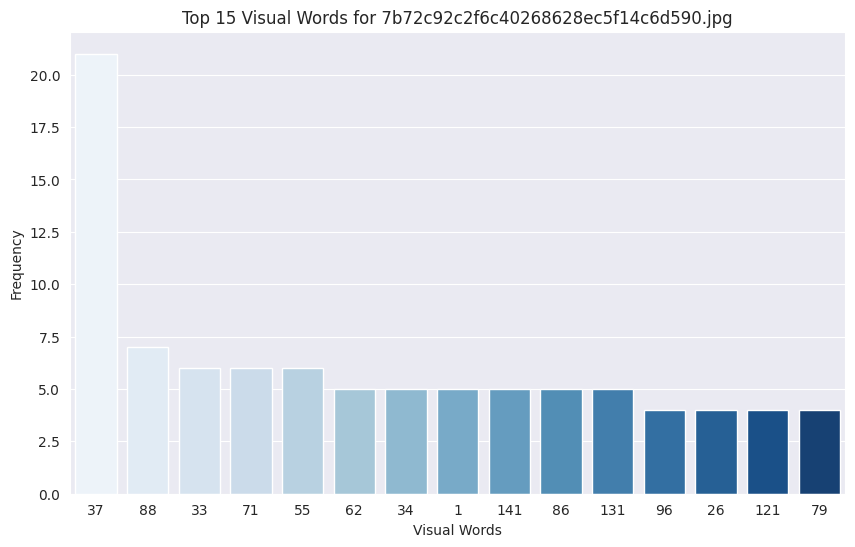

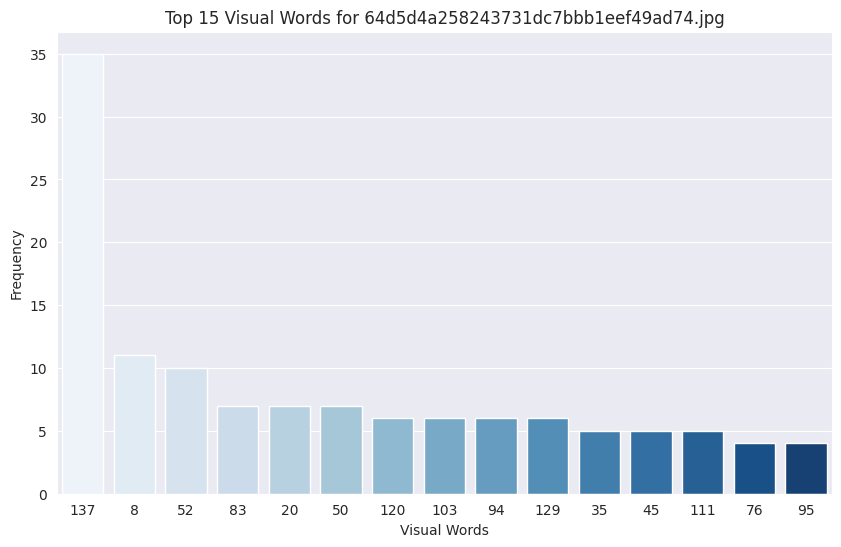

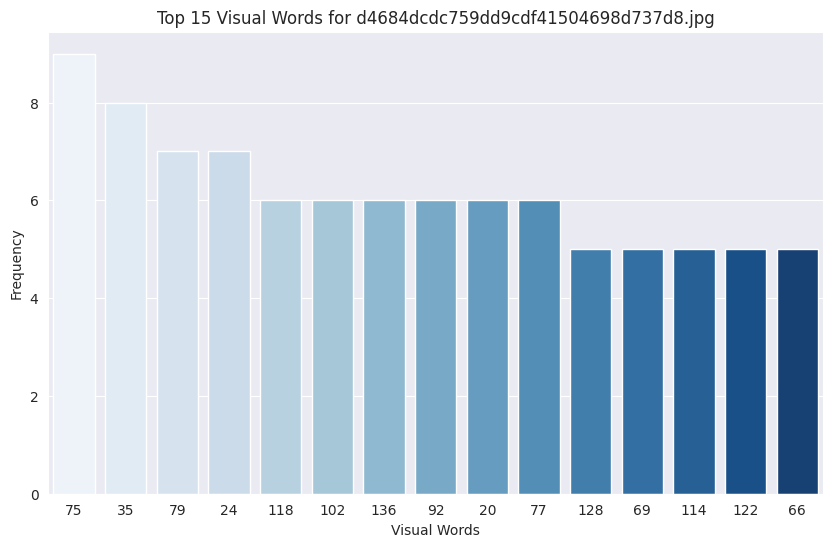

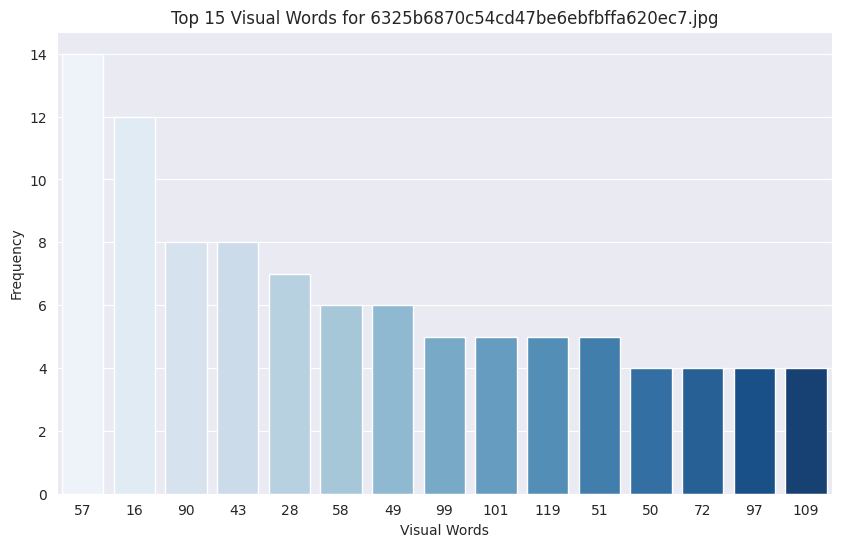

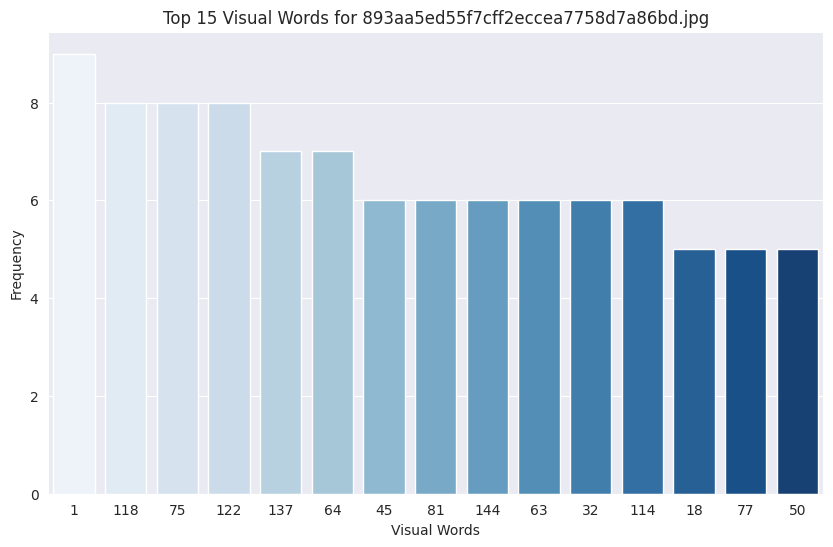

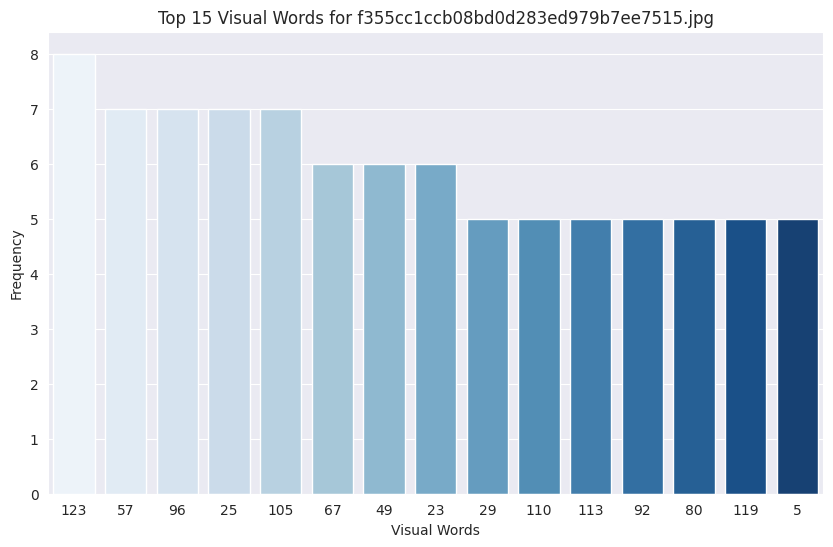

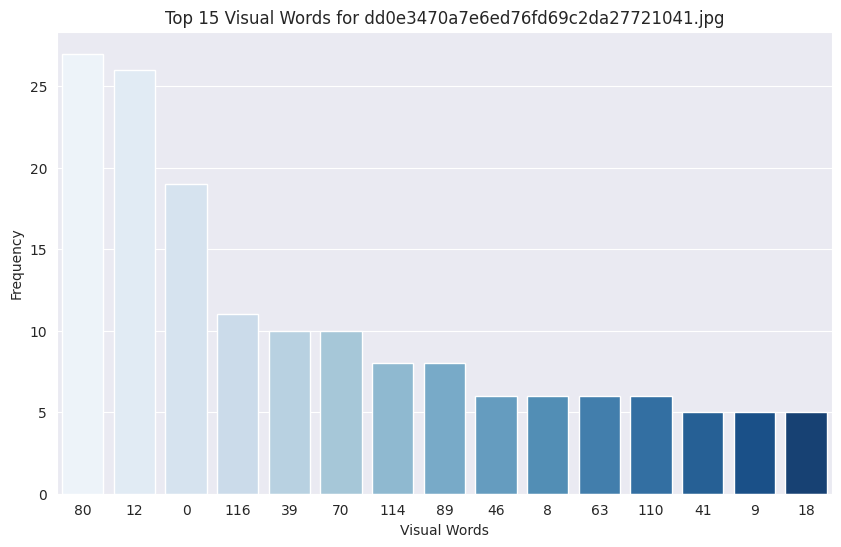

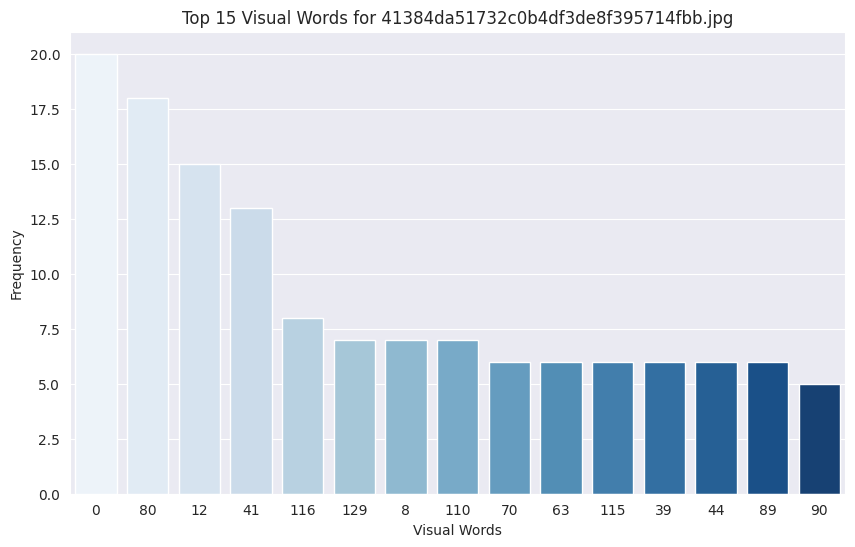

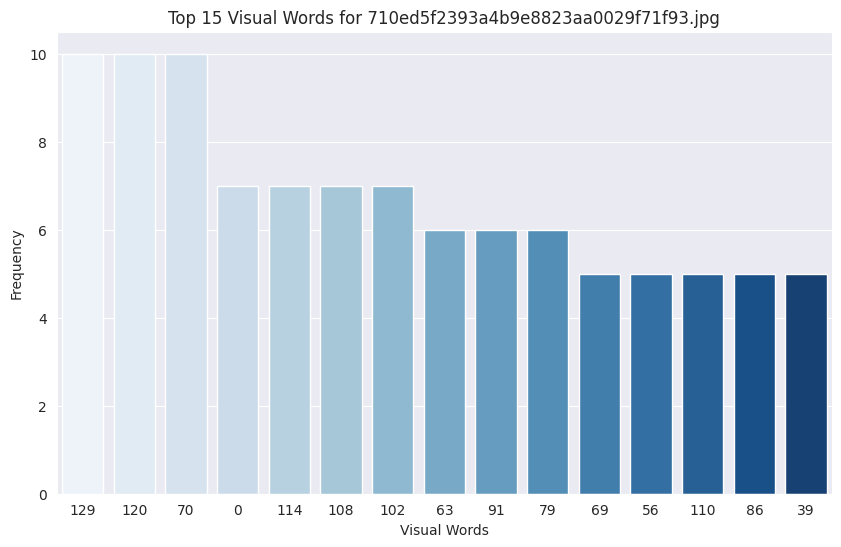

In [23]:
img_file_names = flipkart_clean_df["image"].to_list()

# If image histograms haven't been calculated yet, perform the necessary preprocessing, feature extraction, and clustering
if not os.path.isfile("img_histograms.pkl"):
    # Set minimum dimension of images after resizing, and number of features per image
    min_dimen = 500
    num_feats_per_image = 250
    # Set the image directory and create a list for preprocessed image file names
    image_dir = "/home/gabriel/OC_DS_Projects/OC_DS_P6/Images"
    preproc_image_f_names = []
    # Initialize an ORB object and create a list for ORB descriptors for each image
    orb_descriptors_list = []
    orb = cv2.ORB_create(nfeatures=num_feats_per_image)

    # Loop through each image file, perform preprocessing, feature extraction, and save the preprocessed image
    for file_name in img_file_names:
        # Load image and get its dimensions
        image = Image.open(os.path.join("Images", file_name))
        w, h = image.size

        # Crop image if necessary to obtain aspect ratio between 1/1.25 and 0.8/1, then resize the image to the minimum dimension
        if w < h:
            if h > 1.25 * w:
                top = 0.5 * h - 0.625 * w
                bottom = 0.5 * h + 0.625 * w
                left = 0
                right = w
                image = image.crop((left, top, right, bottom))

            image = image.resize((min_dimen, int(image.height / w * min_dimen)))
        else:
            if w > 1.25 * h:
                top = 0
                bottom = h
                left = 0.5 * w - 0.625 * h
                right = 0.5 * w + 0.625 * h
                image = image.crop((left, top, right, bottom))

            image = image.resize((int(image.width / h * min_dimen), min_dimen))

        # Generate preprocessed image file name and save the preprocessed image
        split_f_name = file_name.split(".")
        preproc_image_f_name = split_f_name[0] + "_preproc." + split_f_name[1]
        preproc_image_f_names += [preproc_image_f_name]
        image.save(os.path.join("Images", preproc_image_f_name))

    # Change current directory to the image directory and loop through each preprocessed image file
    os.chdir(image_dir)

    for i, preproc_image_f_name in enumerate(preproc_image_f_names):
        # Load preprocessed image and perform Gaussian blur, histogram equalization, and conversion to grayscale
        image = cv2.GaussianBlur(
            cv2.equalizeHist(
                cv2.cvtColor(
                    cv2.imread(image_dir + "/" + preproc_image_f_name),
                    cv2.COLOR_BGR2GRAY,
                )
            ),
            (5, 5),
            cv2.BORDER_DEFAULT,
        )
        # Detect ORB keypoints and descriptors for the preprocessed image, and adjust the number of descriptors if necessary
        keypoints, descriptors = orb.detectAndCompute(image, None)

        if descriptors is None:
            descriptors = np.zeros((num_feats_per_image, 32), dtype=np.uint8)
        else:
            if descriptors.shape[0] < num_feats_per_image:
                descriptors = np.concatenate(
                    (
                        descriptors,
                        np.zeros(
                            (num_feats_per_image - descriptors.shape[0], 32),
                            dtype=np.uint8,
                        ),
                    )
                )
            elif descriptors.shape[0] > num_feats_per_image:
                descriptors = descriptors[:num_feats_per_image, :]

        orb_descriptors_list += [descriptors]

        # Save preprocessed image
        cv2.imwrite(preproc_image_f_name, image)

        # Save images with keypoints for the first 10 images
        if i < 10:
            split_f_name = img_file_names[i].split(".")

            cv2.imwrite(
                split_f_name[0] + "_keypoints." + split_f_name[1],
                cv2.drawKeypoints(image, keypoints, None, (0, 0, 255), flags=0),
            )

    # Return to project directory
    os.chdir("/home/gabriel/OC_DS_Projects/OC_DS_P6")

    # Convert the list of ORB descriptors to a numpy array
    orb_descriptors_array = np.array(orb_descriptors_list)

    # inertias = []
    # vis_vocab_len_range = range(100, 501, 50)

    # for vis_vocab_len in vis_vocab_len_range:
    #     inertias.append(KMeans(n_clusters=vis_vocab_len, n_init=10, random_state=0).fit(orb_descriptors_array.reshape(-1, 32)).inertia_)

    # vis_vocab_len = KneeLocator(list(vis_vocab_len_range), inertias, curve="convex", direction="decreasing").knee
    
    # Determine the number of visual words (clusters) using KMeans
    vis_vocab_len = 150

    vis_word_kmeans = KMeans(n_clusters=vis_vocab_len, n_init=10, random_state=0).fit(
        orb_descriptors_array.reshape(-1, 32)
    )
    # Calculate the image histograms using the visual word clusters
    img_histograms = np.zeros((orb_descriptors_array.shape[0], vis_vocab_len))

    for i in range(orb_descriptors_array.shape[0]):
        for j in range(orb_descriptors_array.shape[1]):
            img_histograms[
                i,
                vis_word_kmeans.predict(orb_descriptors_array[i, j, :].reshape(1, -1))[
                    0
                ],
            ] += 1

    # Save the image histograms to a file
    pickle.dump(img_histograms, open("img_histograms.pkl", "wb"))
else:
    img_histograms = pickle.load(open("img_histograms.pkl", "rb"))

# Plot best clustering depending on dimensionality reduction technique
cluster_plot_vectors("BoVW with ORB", img_histograms)

# Plot the top 15 visual words for the first 10 images
for i in range(10):
    img_hist = img_histograms[i, :]
    top_words_idx = img_hist.argsort()[-15:][::-1]
    fig, ax = plt.subplots(figsize=(10, 6))
    file_name = img_file_names[i]
    split_f_name = file_name.split(".")

    sns.barplot(
        x=[str(idx) for idx in top_words_idx],
        y=img_hist[top_words_idx].astype(int),
        ax=ax,
        palette="Blues",
    )
    ax.set_xlabel("Visual Words")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Top 15 Visual Words for {file_name}")
    plt.savefig(os.path.join("Images", split_f_name[0] + "_hist.png"))


ResNet (Clustered on Vectors Directly); Accuracy: 30.0%, ARI: 0.205
ResNet (Clustered on PCA Reduced); Accuracy: 33.05%, ARI: 0.4139
ResNet (Clustered on TSNE Reduced); Accuracy: 23.24%, ARI: 0.3117
ResNet (Clustered on PCA and TSNE Reduced); Accuracy: 6.1%, ARI: 0.3395


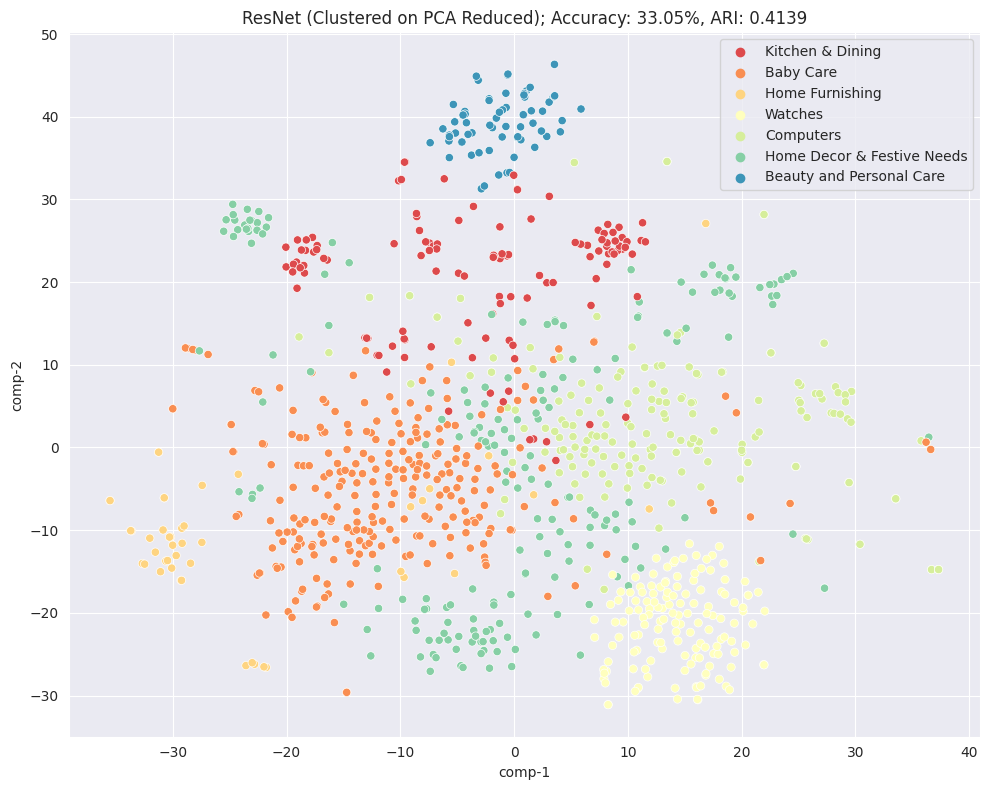

In [24]:
# Check if the ResNet features have already been calculated
if not os.path.isfile("resnet_features.pkl"):
    # Load ResNet50 model trained on ImageNet dataset without the last dense layer
    resnet_model = ResNet50(weights="imagenet", include_top=False)
    resnet_features = []

    # Loop through each image and extract the features using the ResNet model
    for file_name in img_file_names:
        # Open the image and resize it to 224x224 as required by ResNet50
        image = Image.open(os.path.join("Images", file_name)).resize((224, 224))
        # Preprocess the image
        preproc_image = preprocess_input(np.array(image))
        # Extract features and flatten the output
        image_feats = resnet_model.predict(np.array([preproc_image])).flatten()

        # Add extracted features to list
        resnet_features.append(image_feats)

    # Convert the matrix of ResNet features to a numpy array
    resnet_features = np.array(resnet_features)
    # Save the matrix of extracted features
    pickle.dump(resnet_features, open("resnet_features.pkl", "wb"))
else:
    # Load features if they've already been extracted
    resnet_features = pickle.load(open("resnet_features.pkl", "rb"))

# Plot best clustering of features depending on dimensionality reduction technique
cluster_plot_vectors("ResNet", resnet_features)
